url: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing#description

The challenge is formulated by Mercedes Benz and consists of reducing the time cars spend on the test bench. Competitors will work with a dataset representing different permutations of Mercedes-Benz car features to predict the time it takes to pass testing. Winning algorithms will contribute to speedier testing, resulting in lower carbon dioxide emissions without reducing Daimler’s standards.

Submissions are evaluated on the R^2 values, also known as coefficient of determination. For each ID, a competitor must predict the 'y' variable; the time that it takes for a new car to pass testing



##### DESCRIPTION OF THE DATA #####
The dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes Car. For example, a variable could be 4WD, added air suspension, or a head-up display. The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.
Two files are uploaded:
train.csv - the training set
test. csv - the test set, you must predict the 'y' variable for the 'ID's in this file





In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

from sklearn.ensemble import RandomForestRegressor

np.random.seed(1)
import random as rn
rn.seed(1)
import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
import keras as k
from keras.layers import Dense
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

#Model evaluation
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

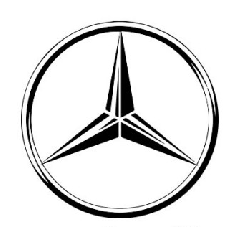

In [43]:
# Load image - for design purposes
img = mpimg.imread('logo.png')
fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [44]:
# Load Train and Test Data
train_data = pd.read_csv('train.csv', sep = ',')
X_test = pd.read_csv('test.csv', sep = ',')
X_train = train_data.drop('y', axis = 1) # drop y from the train and assign that y (target) to y_train
y_train = pd.DataFrame(train_data ['y'])

Before we start any work, I like to check if we have any missing values

In [49]:
missing_vals_train = train_data.isnull().sum(axis=0)
missing_vals_test = X_test.isnull().sum(axis=0)
print ('Train: ', missing_vals_train)
print ('\n Test: ', missing_vals_test )

Train:  ID      0
y       0
X0      0
X1      0
X2      0
X3      0
X4      0
X5      0
X6      0
X8      0
X10     0
X11     0
X12     0
X13     0
X14     0
X15     0
X16     0
X17     0
X18     0
X19     0
X20     0
X21     0
X22     0
X23     0
X24     0
X26     0
X27     0
X28     0
X29     0
X30     0
       ..
X355    0
X356    0
X357    0
X358    0
X359    0
X360    0
X361    0
X362    0
X363    0
X364    0
X365    0
X366    0
X367    0
X368    0
X369    0
X370    0
X371    0
X372    0
X373    0
X374    0
X375    0
X376    0
X377    0
X378    0
X379    0
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64

 Test:  ID      0
X0      0
X1      0
X2      0
X3      0
X4      0
X5      0
X6      0
X8      0
X10     0
X11     0
X12     0
X13     0
X14     0
X15     0
X16     0
X17     0
X18     0
X19     0
X20     0
X21     0
X22     0
X23     0
X24     0
X26     0
X27     0
X28     0
X29     0
X30     0
X31     0
       ..
X355    0
X356    0
X357    0
X358   

Text(0,0.5,'y (target) values')

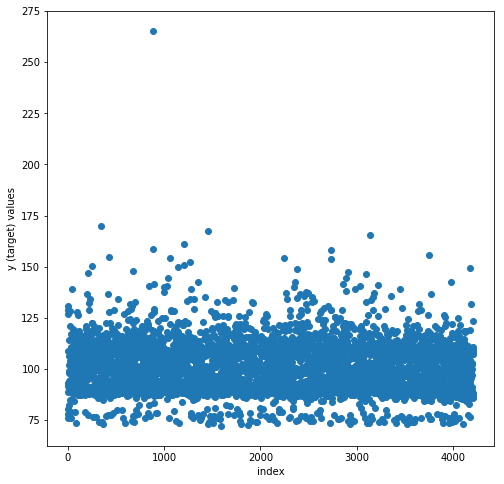

In [50]:
##### Data Exploration Stage #####
# Plot y variable
plt.figure(figsize = (8,8))
plt.scatter(range(len(train_data)), np.sort(y_train))
plt.xlabel ('index')
plt.ylabel ('y (target) values')


It is easy to see that there is a single outlier. It is possible to visualize the same plot for the target variable using a different plot

Text(0,0.5,'Sorted y (target) values')

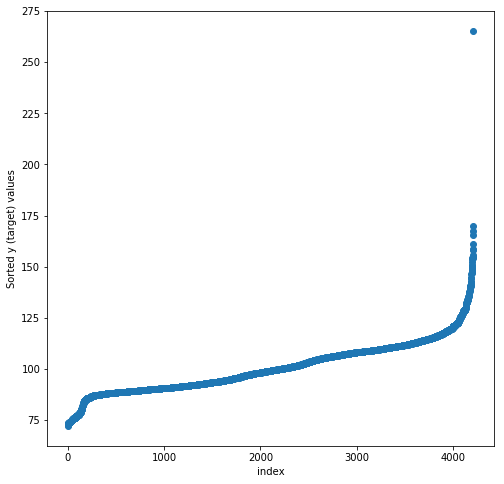

In [51]:

plt.figure(figsize = (8,8))
plt.scatter(range(train_data.shape[0]), np.sort(train_data['y']))
plt.xlabel ('index')
plt.ylabel ('Sorted y (target) values')


An outlier might affect the performance of an algorithm: It is the best to either remove it, or impute it.
From the graphs, it is obvious that the y value for that outlier is approximately 270. To be on the safe side, let's
enforce the condition for the outlier to be >190; the value it will definitely satisfy. Instead of removing it, 
the outlier will be imputed using the mean-value approach.

In [52]:
y_train.loc[y_train['y']>190] = y_train ['y'].mean ()

Text(0,0.5,'Sorted y (target) values')

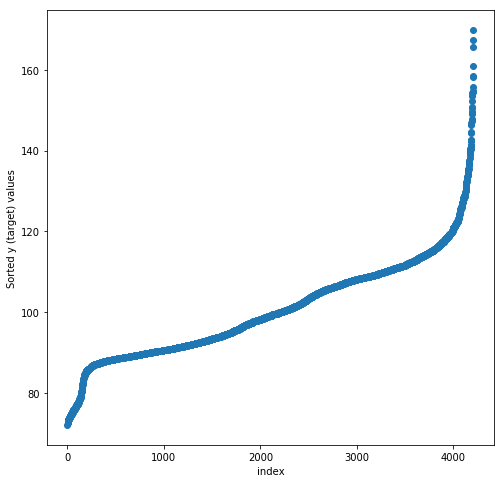

In [53]:
# Plot again
sorted_vals = sorted (y_train.values)
plt.figure(figsize = (8,8))
plt.scatter(range(len(train_data)), sorted_vals)
plt.xlabel ('index')
plt.ylabel ('Sorted y (target) values')

Solved the issue with the outlier and no more outliers are present. Now we can explore the X_train dataframe

In [54]:
dict (Counter(X_train.dtypes))

{dtype('int64'): 369, dtype('O'): 8}

In [55]:
dict (X_train.columns.to_series().groupby(X_train.dtypes).groups)

{dtype('int64'): Index(['ID', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18',
        ...
        'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
        'X385'],
       dtype='object', length=369),
 dtype('O'): Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')}

We can see that 369 features are int64. There are 8 categorical features, namely; ID, X0, X1, X2, X3, X4, X5, X6, X7, X8. 
Of course, I can do feature reduction at this point, but I want to see if I can manually reduce features.
A good approach is to get rid of the features that have no variations. 

In [56]:
unique_values_dict = {}
for col in X_train.columns:
    if col not in ['ID', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']:
        unique_value = str(np.sort(X_train[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist [:]

In [57]:
# I want to print them to see if I can drop any 
for unique_value, columns in unique_values_dict.items():
    print ('\nColumns that have unique values are ', unique_value )
    print (columns)



Columns that have unique values are  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 

In [58]:
# There are 12 features that have no variance at all. Drop them
X_train = X_train.drop(columns=unique_values_dict['[0]'], axis=1)
X_train = X_train.drop(['ID'], axis = 1)
X_test = X_test.drop(columns=unique_values_dict['[0]'], axis=1)  
X_test = X_test.drop(['ID'], axis = 1)  

There are 8 categorical features, and they need to be converted to numerical representation. The two common methods are LabelEncoder or OneHotEncoder. The problem with OneHotEncoder is that it ttakes a column which has categorical data, and then splits that column into multiple columns. The numbers are replaced by 1 and 0, depending on which column has what value. So, if we have France, Germany and Spain, we will get 3 new columns. LabelEncoder though, replaces categorical data with values from 0 to n_classes - 1

In [59]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

for cf in list(X_train.columns):
    if cf in categorical_features:
        lbl = LabelEncoder()
        X_train[cf] = lbl.fit_transform(X_train[cf].values)
        X_test[cf] = lbl.fit_transform(X_test[cf].values)


In [60]:
# If we print first 5 rows, we will see that X0, X1 ... X8 have numerical representation
X_train.head()

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,32,23,17,0,3,24,9,14,0,0,...,0,0,1,0,0,0,0,0,0,0
1,32,21,19,4,3,28,11,14,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,24,34,2,3,27,9,23,0,0,...,0,0,0,0,0,0,1,0,0,0
3,20,21,34,5,3,27,11,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20,23,34,5,3,12,3,13,0,0,...,0,0,0,0,0,0,0,0,0,0


At this moment I can start with feature selection algorithm and take a look at what features are important for target prediction. For that we use embedded method feature selection called Random Forest feature selection

In [62]:
feature_labels = X_train.columns
forest_model = RandomForestRegressor(n_estimators = 1000, random_state = 0, n_jobs = -1) # -1 mean that trees are constructed in parallel
forest_model.fit (X_train, y_train)
importance = forest_model.feature_importances_  

In [63]:
indices = np.argsort(importance)[::-1]
order_features = []
order_importances = []
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feature_labels[f], importance[indices[f]]))
    order_features.append(feature_labels[f])
    order_importances.append(importance[indices[f]])

 1) X0                             0.393492
 2) X1                             0.075732
 3) X2                             0.065282
 4) X3                             0.033986
 5) X4                             0.031957
 6) X5                             0.029065
 7) X6                             0.027367
 8) X8                             0.019343
 9) X10                            0.016282
10) X12                            0.012359
11) X13                            0.011961
12) X14                            0.010098
13) X15                            0.008575
14) X16                            0.008459
15) X17                            0.008198
16) X18                            0.007110
17) X19                            0.006683
18) X20                            0.006290
19) X21                            0.006074
20) X22                            0.005243
21) X23                            0.004505
22) X24                            0.003442
23) X26                         

We can drop the features that are not as important as the others in predicting the target function. After 243 variables, the score moved to 4 zeros and I decided to cut-off at that point. 

In [64]:
X_train = X_train.drop(order_features[243:],axis = 1)
X_test = X_test.drop(order_features[243:],axis = 1)


In [65]:
# Run with RFRegressor
kf = KFold (n_splits = 5, random_state = 42, shuffle = True)
r2_scores_test = []
r2_scores_train = []
for train_index, test_index in kf.split(X_train):
    X_train_folded, X_test_folded = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_folded, y_test_folded = y_train.iloc[train_index], y_train.iloc[test_index]

    rf_model = RandomForestRegressor (n_estimators=20, oob_score=True, bootstrap=True, max_depth = 4)
    rf_model.fit(X_train_folded,y_train_folded)
    r2_score_train = r2_score (y_train_folded, rf_model.predict(X_train_folded))
    r2_scores_train.append(r2_score_train)
    r2_score_test = r2_score(y_test_folded, rf_model.predict(X_test_folded))
    r2_scores_test.append(r2_score_test)

print ('\n R2 score for training: %.3f' % np.mean(r2_scores_train), 
       '\n R2 score for testing: %.3f' % np.mean(r2_scores_test))

print (r2_scores_test)



 R2 score for training: 0.615 
 R2 score for testing: 0.594
[0.5964290939674699, 0.5526589138658882, 0.5994815691662648, 0.6230623256893242, 0.5998946344761373]


In [69]:
from sklearn.model_selection import RandomizedSearchCV

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def create_model(activation_1='relu', activation_2='relu', 
                 neurons_hidden_1 = 1, neurons_hidden_2 = 1,
                 #learning_rate=1,
                 input_shape=(X_train.shape[1],)):
    model = Sequential()
    model.add(Dense(neurons_hidden_1, activation=activation_1, input_shape=input_shape, 
                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42), 
                  bias_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42)))
    
    model.add(Dense(neurons_hidden_2, activation=activation_1, input_shape=input_shape, 
                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42), 
                  bias_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42)))
    
    model.add(Dense(1, activation='linear'))
    model.compile (loss = 'mean_squared_error', metrics=[r2_keras], optimizer=k.optimizers.Adam(lr=1e-3))
    return model

param_grid = {
    'neurons_hidden_1':[1, 5, 10, 15, 20, 25, 30, 35],
    'neurons_hidden_2':[1, 5, 10, 15, 20, 25, 30, 35],
    'batch_size': [32,64,128]
}



clf=KerasRegressor(build_fn=create_model, epochs=150, verbose=1)
rs_keras = RandomizedSearchCV(clf, param_grid, cv=5, 
                              scoring='r2', refit='r2', 
                              verbose=3, n_jobs=1,random_state=42)
rs_keras.fit(X_train, y_train)
rs_keras.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] neurons_hidden_2=25, neurons_hidden_1=25, batch_size=32 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/150
3367/3367 [==============================] - 15s 4ms/step - loss: 7062.3940 - r2_keras: -53.0078
Epoch 2/150
3367/3367 [==============================] - 1s 394us/step - loss: 408.5946 - r2_keras: -1.8436
Epoch 3/150
3367/3367 [==============================] - 1s 397us/step - loss: 303.4905 - r2_keras: -1.1561
Epoch 4/150
3367/3367 [==============================] - 1s 419us/step - loss: 222.3701 - r2_keras: -0.5419
Epoch 5/150
3367/3367 [==============================] - 1s 392us/step - loss: 173.2043 - r2_keras: -0.1798
Epoch 6/150
3367/3367 [==============================] - 1s 389us/step - loss: 145.0759 - r2_keras: 0.0181
Epoch 7/150
3367/3367 [==============================] - 1s 386us/step - loss: 126.8359 - r2_keras: 0.1449
Epoch 8/150
3367/3367 [==============================] - 1s 383us/step - loss: 115.7473 - r2_keras: 0.2275
Epoch 9/150
3367/3367 [==============================] - 1s 420us/step - loss: 107.1993 - r2_keras: 0.2757
Epoch 10/150
3367/3367 [=======

3367/3367 [==============================] - 1s 399us/step - loss: 63.2964 - r2_keras: 0.5931
Epoch 78/150
3367/3367 [==============================] - 1s 421us/step - loss: 62.7179 - r2_keras: 0.5986
Epoch 79/150
3367/3367 [==============================] - 2s 511us/step - loss: 62.8521 - r2_keras: 0.5955 0s - loss: 62.4230 - r2_keras: 0.59
Epoch 80/150
3367/3367 [==============================] - 2s 516us/step - loss: 62.9766 - r2_keras: 0.5901 0s - loss: 66.5207 - r2_keras:  - ETA: 0s - loss: 66.3594 - r2_keras: 0.575 - ETA: 0s - loss: 65.3998 - r2_keras
Epoch 81/150
3367/3367 [==============================] - 2s 452us/step - loss: 63.0073 - r2_keras: 0.5957
Epoch 82/150
3367/3367 [==============================] - 1s 418us/step - loss: 64.0071 - r2_keras: 0.5866
Epoch 83/150
3367/3367 [==============================] - 2s 464us/step - loss: 63.0680 - r2_keras: 0.5838
Epoch 84/150
3367/3367 [==============================] - 1s 434us/step - loss: 63.5811 - r2_keras: 0.5835
Epoch 85

3367/3367 [==============================] - 1s 336us/step
[CV]  neurons_hidden_2=25, neurons_hidden_1=25, batch_size=32, score=0.5486826246444951, total= 3.7min
[CV] neurons_hidden_2=25, neurons_hidden_1=25, batch_size=32 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


Epoch 1/150
3367/3367 [==============================] - 13s 4ms/step - loss: 5355.2401 - r2_keras: -40.0050
Epoch 2/150
3367/3367 [==============================] - 1s 350us/step - loss: 368.7381 - r2_keras: -1.6778
Epoch 3/150
3367/3367 [==============================] - 1s 386us/step - loss: 299.1457 - r2_keras: -1.1460
Epoch 4/150
3367/3367 [==============================] - 1s 364us/step - loss: 220.5752 - r2_keras: -0.5772
Epoch 5/150
3367/3367 [==============================] - 1s 367us/step - loss: 166.1747 - r2_keras: -0.1698
Epoch 6/150
3367/3367 [==============================] - 1s 373us/step - loss: 135.0995 - r2_keras: 0.0528
Epoch 7/150
3367/3367 [==============================] - 1s 380us/step - loss: 116.6047 - r2_keras: 0.1857
Epoch 8/150
3367/3367 [==============================] - 1s 444us/step - loss: 105.8864 - r2_keras: 0.2635
Epoch 9/150
3367/3367 [==============================] - 1s 370us/step - loss: 98.5749 - r2_keras: 0.3123
Epoch 10/150
3367/3367 [========

3367/3367 [==============================] - 1s 369us/step - loss: 57.9303 - r2_keras: 0.6093
Epoch 78/150
3367/3367 [==============================] - 1s 383us/step - loss: 56.9951 - r2_keras: 0.6135
Epoch 79/150
3367/3367 [==============================] - 1s 378us/step - loss: 57.0697 - r2_keras: 0.6116
Epoch 80/150
3367/3367 [==============================] - 1s 392us/step - loss: 57.4638 - r2_keras: 0.6104
Epoch 81/150
3367/3367 [==============================] - 1s 375us/step - loss: 58.1169 - r2_keras: 0.6060
Epoch 82/150
3367/3367 [==============================] - 1s 370us/step - loss: 57.2416 - r2_keras: 0.6101
Epoch 83/150
3367/3367 [==============================] - 1s 360us/step - loss: 56.4363 - r2_keras: 0.6167
Epoch 84/150
3367/3367 [==============================] - 1s 375us/step - loss: 58.4914 - r2_keras: 0.6005
Epoch 85/150
3367/3367 [==============================] - 1s 379us/step - loss: 56.2152 - r2_keras: 0.6200
Epoch 86/150
3367/3367 [==========================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.3min remaining:    0.0s


Epoch 1/150
3367/3367 [==============================] - 14s 4ms/step - loss: 4851.9675 - r2_keras: -35.2982
Epoch 2/150
3367/3367 [==============================] - 1s 382us/step - loss: 399.4816 - r2_keras: -1.8232
Epoch 3/150
3367/3367 [==============================] - 1s 363us/step - loss: 300.8495 - r2_keras: -1.0667
Epoch 4/150
3367/3367 [==============================] - 1s 415us/step - loss: 201.6228 - r2_keras: -0.3825
Epoch 5/150
3367/3367 [==============================] - 1s 363us/step - loss: 147.7639 - r2_keras: -0.0106
Epoch 6/150
3367/3367 [==============================] - 1s 392us/step - loss: 122.6549 - r2_keras: 0.1800
Epoch 7/150
3367/3367 [==============================] - 1s 365us/step - loss: 108.3554 - r2_keras: 0.2739
Epoch 8/150
3367/3367 [==============================] - 1s 358us/step - loss: 99.0439 - r2_keras: 0.3277
Epoch 9/150
3367/3367 [==============================] - 1s 367us/step - loss: 92.4993 - r2_keras: 0.3934
Epoch 10/150
3367/3367 [=========

3367/3367 [==============================] - 1s 358us/step - loss: 60.5526 - r2_keras: 0.6085
Epoch 78/150
3367/3367 [==============================] - 1s 376us/step - loss: 62.7610 - r2_keras: 0.5927
Epoch 79/150
3367/3367 [==============================] - 1s 362us/step - loss: 60.7158 - r2_keras: 0.6095
Epoch 80/150
3367/3367 [==============================] - 1s 376us/step - loss: 60.9807 - r2_keras: 0.6004
Epoch 81/150
3367/3367 [==============================] - 1s 368us/step - loss: 60.0429 - r2_keras: 0.6111
Epoch 82/150
3367/3367 [==============================] - 1s 363us/step - loss: 59.5757 - r2_keras: 0.6129
Epoch 83/150
3367/3367 [==============================] - 1s 366us/step - loss: 60.0698 - r2_keras: 0.6109
Epoch 84/150
3367/3367 [==============================] - 1s 383us/step - loss: 60.9625 - r2_keras: 0.6103
Epoch 85/150
3367/3367 [==============================] - 1s 370us/step - loss: 61.2346 - r2_keras: 0.5986
Epoch 86/150
3367/3367 [==========================

Epoch 1/150
3367/3367 [==============================] - 13s 4ms/step - loss: 5000.4645 - r2_keras: -35.2639
Epoch 2/150
3367/3367 [==============================] - 1s 357us/step - loss: 390.4770 - r2_keras: -1.8135
Epoch 3/150
3367/3367 [==============================] - 1s 350us/step - loss: 313.8398 - r2_keras: -1.2341
Epoch 4/150
3367/3367 [==============================] - 1s 361us/step - loss: 244.3352 - r2_keras: -0.7297
Epoch 5/150
3367/3367 [==============================] - 1s 359us/step - loss: 189.5719 - r2_keras: -0.3344
Epoch 6/150
3367/3367 [==============================] - 1s 357us/step - loss: 152.5789 - r2_keras: -0.0607
Epoch 7/150
3367/3367 [==============================] - 1s 364us/step - loss: 128.9566 - r2_keras: 0.1225
Epoch 8/150
3367/3367 [==============================] - 1s 357us/step - loss: 114.2084 - r2_keras: 0.2308
Epoch 9/150
3367/3367 [==============================] - 1s 365us/step - loss: 102.9123 - r2_keras: 0.3039
Epoch 10/150
3367/3367 [======

3367/3367 [==============================] - 1s 352us/step - loss: 58.0422 - r2_keras: 0.6116
Epoch 78/150
3367/3367 [==============================] - 1s 378us/step - loss: 58.5173 - r2_keras: 0.6217
Epoch 79/150
3367/3367 [==============================] - 1s 367us/step - loss: 57.4815 - r2_keras: 0.6209
Epoch 80/150
3367/3367 [==============================] - 1s 353us/step - loss: 57.6624 - r2_keras: 0.6249
Epoch 81/150
3367/3367 [==============================] - 1s 362us/step - loss: 57.6973 - r2_keras: 0.6242
Epoch 82/150
3367/3367 [==============================] - 1s 358us/step - loss: 57.4537 - r2_keras: 0.6249
Epoch 83/150
3367/3367 [==============================] - 1s 362us/step - loss: 57.9040 - r2_keras: 0.6115
Epoch 84/150
3367/3367 [==============================] - 1s 352us/step - loss: 57.5388 - r2_keras: 0.6212
Epoch 85/150
3367/3367 [==============================] - 1s 361us/step - loss: 58.0579 - r2_keras: 0.6121
Epoch 86/150
3367/3367 [==========================

Epoch 1/150
3368/3368 [==============================] - 13s 4ms/step - loss: 4608.0679 - r2_keras: -33.0014
Epoch 2/150
3368/3368 [==============================] - 1s 368us/step - loss: 368.8055 - r2_keras: -1.5544
Epoch 3/150
3368/3368 [==============================] - 1s 368us/step - loss: 264.1526 - r2_keras: -0.8043
Epoch 4/150
3368/3368 [==============================] - 1s 385us/step - loss: 179.9869 - r2_keras: -0.2065
Epoch 5/150
3368/3368 [==============================] - 1s 381us/step - loss: 141.9646 - r2_keras: 0.0448
Epoch 6/150
3368/3368 [==============================] - 1s 379us/step - loss: 120.8481 - r2_keras: 0.2068
Epoch 7/150
3368/3368 [==============================] - 1s 374us/step - loss: 109.1112 - r2_keras: 0.2980
Epoch 8/150
3368/3368 [==============================] - 1s 370us/step - loss: 100.4078 - r2_keras: 0.3505
Epoch 9/150
3368/3368 [==============================] - 1s 363us/step - loss: 93.7379 - r2_keras: 0.3973
Epoch 10/150
3368/3368 [=========

3368/3368 [==============================] - 1s 388us/step - loss: 64.7799 - r2_keras: 0.5928
Epoch 78/150
3368/3368 [==============================] - 1s 372us/step - loss: 64.6213 - r2_keras: 0.5935
Epoch 79/150
3368/3368 [==============================] - 1s 364us/step - loss: 66.3855 - r2_keras: 0.5829
Epoch 80/150
3368/3368 [==============================] - 1s 364us/step - loss: 66.1187 - r2_keras: 0.5887
Epoch 81/150
3368/3368 [==============================] - 1s 377us/step - loss: 65.2069 - r2_keras: 0.5937
Epoch 82/150
3368/3368 [==============================] - 1s 362us/step - loss: 65.7016 - r2_keras: 0.5882
Epoch 83/150
3368/3368 [==============================] - 1s 367us/step - loss: 65.1240 - r2_keras: 0.5883
Epoch 84/150
3368/3368 [==============================] - 1s 362us/step - loss: 64.8354 - r2_keras: 0.5911
Epoch 85/150
3368/3368 [==============================] - 1s 356us/step - loss: 64.8186 - r2_keras: 0.5925
Epoch 86/150
3368/3368 [==========================

Epoch 1/150
3367/3367 [==============================] - 12s 4ms/step - loss: 10255.2428 - r2_keras: -67.8658
Epoch 2/150
3367/3367 [==============================] - 0s 110us/step - loss: 10249.8101 - r2_keras: -67.2911
Epoch 3/150
3367/3367 [==============================] - 0s 107us/step - loss: 10244.3719 - r2_keras: -66.8370
Epoch 4/150
3367/3367 [==============================] - 0s 105us/step - loss: 10238.9456 - r2_keras: -66.9682
Epoch 5/150
3367/3367 [==============================] - 0s 120us/step - loss: 10233.5246 - r2_keras: -67.7267
Epoch 6/150
3367/3367 [==============================] - 0s 125us/step - loss: 10228.1051 - r2_keras: -67.1490
Epoch 7/150
3367/3367 [==============================] - 0s 111us/step - loss: 10222.6892 - r2_keras: -66.7697
Epoch 8/150
3367/3367 [==============================] - 0s 104us/step - loss: 10217.2723 - r2_keras: -67.4873
Epoch 9/150
3367/3367 [==============================] - 0s 108us/step - loss: 10211.8555 - r2_keras: -66.9850
Ep

3367/3367 [==============================] - 0s 110us/step - loss: 9864.3818 - r2_keras: -65.4805
Epoch 75/150
3367/3367 [==============================] - 0s 112us/step - loss: 9859.0961 - r2_keras: -64.9455
Epoch 76/150
3367/3367 [==============================] - 0s 114us/step - loss: 9853.8145 - r2_keras: -63.9534
Epoch 77/150
3367/3367 [==============================] - 0s 112us/step - loss: 9848.5315 - r2_keras: -65.5612
Epoch 78/150
3367/3367 [==============================] - 0s 109us/step - loss: 9843.2502 - r2_keras: -64.5240
Epoch 79/150
3367/3367 [==============================] - 0s 109us/step - loss: 9837.9727 - r2_keras: -64.3888
Epoch 80/150
3367/3367 [==============================] - 0s 114us/step - loss: 9832.6957 - r2_keras: -63.8116
Epoch 81/150
3367/3367 [==============================] - 0s 113us/step - loss: 9827.4184 - r2_keras: -64.8115
Epoch 82/150
3367/3367 [==============================] - 0s 108us/step - loss: 9822.1455 - r2_keras: -65.2285
Epoch 83/150
3

3367/3367 [==============================] - 0s 106us/step - loss: 9482.9903 - r2_keras: -61.8488
Epoch 148/150
3367/3367 [==============================] - 0s 113us/step - loss: 9477.8220 - r2_keras: -61.7098
Epoch 149/150
3367/3367 [==============================] - 0s 110us/step - loss: 9472.6580 - r2_keras: -62.7604
Epoch 150/150
3367/3367 [==============================] - 0s 106us/step
[CV]  neurons_hidden_2=1, neurons_hidden_1=5, batch_size=128, score=-61.705708105330004, total= 1.2min
[CV] neurons_hidden_2=1, neurons_hidden_1=5, batch_size=128 ..........
Epoch 1/150
3367/3367 [==============================] - 12s 4ms/step - loss: 10229.5926 - r2_keras: -69.6660
Epoch 2/150
3367/3367 [==============================] - 0s 117us/step - loss: 10224.1638 - r2_keras: -69.6941
Epoch 3/150
3367/3367 [==============================] - 0s 112us/step - loss: 10218.7362 - r2_keras: -71.0890
Epoch 4/150
3367/3367 [==============================] - 0s 110us/step - loss: 10213.3098 - r2_kera

3367/3367 [==============================] - 0s 114us/step - loss: 9870.8262 - r2_keras: -66.4164
Epoch 69/150
3367/3367 [==============================] - 0s 110us/step - loss: 9865.5396 - r2_keras: -67.3516
Epoch 70/150
3367/3367 [==============================] - 0s 110us/step - loss: 9860.2570 - r2_keras: -66.5289
Epoch 71/150
3367/3367 [==============================] - 0s 113us/step - loss: 9854.9763 - r2_keras: -67.2763
Epoch 72/150
3367/3367 [==============================] - 0s 110us/step - loss: 9849.6902 - r2_keras: -67.3453
Epoch 73/150
3367/3367 [==============================] - 0s 110us/step - loss: 9844.4080 - r2_keras: -66.4852
Epoch 74/150
3367/3367 [==============================] - 0s 111us/step - loss: 9839.1284 - r2_keras: -66.5770
Epoch 75/150
3367/3367 [==============================] - 0s 110us/step - loss: 9833.8500 - r2_keras: -66.5536
Epoch 76/150
3367/3367 [==============================] - 0s 108us/step - loss: 9828.5744 - r2_keras: -67.2994
Epoch 77/150
3

3367/3367 [==============================] - 0s 114us/step - loss: 9489.1340 - r2_keras: -64.0179
Epoch 142/150
3367/3367 [==============================] - 0s 120us/step - loss: 9483.9619 - r2_keras: -63.8463
Epoch 143/150
3367/3367 [==============================] - 0s 115us/step - loss: 9478.7972 - r2_keras: -63.7024
Epoch 144/150
3367/3367 [==============================] - 0s 121us/step - loss: 9473.6294 - r2_keras: -64.1202
Epoch 145/150
3367/3367 [==============================] - 0s 111us/step - loss: 9468.4638 - r2_keras: -65.4567
Epoch 146/150
3367/3367 [==============================] - 0s 114us/step - loss: 9463.2978 - r2_keras: -64.6517
Epoch 147/150
3367/3367 [==============================] - 0s 114us/step - loss: 9458.1342 - r2_keras: -64.5957
Epoch 148/150
3367/3367 [==============================] - 0s 124us/step - loss: 9452.9694 - r2_keras: -63.8779
Epoch 149/150
3367/3367 [==============================] - 0s 135us/step - loss: 9447.8054 - r2_keras: -63.2648
Epoch 

3367/3367 [==============================] - 0s 110us/step - loss: 9956.1900 - r2_keras: -64.6921
Epoch 62/150
3367/3367 [==============================] - 0s 117us/step - loss: 9950.8763 - r2_keras: -65.1900
Epoch 63/150
3367/3367 [==============================] - 0s 114us/step - loss: 9945.5625 - r2_keras: -66.0023
Epoch 64/150
3367/3367 [==============================] - 0s 110us/step - loss: 9940.2521 - r2_keras: -65.6980
Epoch 65/150
3367/3367 [==============================] - 0s 111us/step - loss: 9934.9439 - r2_keras: -64.9126
Epoch 66/150
3367/3367 [==============================] - 0s 110us/step - loss: 9929.6391 - r2_keras: -64.8077
Epoch 67/150
3367/3367 [==============================] - 0s 109us/step - loss: 9924.3293 - r2_keras: -65.7807
Epoch 68/150
3367/3367 [==============================] - 0s 114us/step - loss: 9919.0282 - r2_keras: -65.1622
Epoch 69/150
3367/3367 [==============================] - 0s 114us/step - loss: 9913.7248 - r2_keras: -66.0182
Epoch 70/150
3

3367/3367 [==============================] - 0s 109us/step - loss: 9572.7707 - r2_keras: -63.5259
Epoch 135/150
3367/3367 [==============================] - 0s 107us/step - loss: 9567.5796 - r2_keras: -63.1386
Epoch 136/150
3367/3367 [==============================] - 0s 115us/step - loss: 9562.3880 - r2_keras: -62.8286
Epoch 137/150
3367/3367 [==============================] - 0s 116us/step - loss: 9557.1962 - r2_keras: -62.9638
Epoch 138/150
3367/3367 [==============================] - 0s 110us/step - loss: 9552.0121 - r2_keras: -62.8978
Epoch 139/150
3367/3367 [==============================] - 0s 111us/step - loss: 9546.8260 - r2_keras: -62.8246
Epoch 140/150
3367/3367 [==============================] - 0s 113us/step - loss: 9541.6418 - r2_keras: -62.6276
Epoch 141/150
3367/3367 [==============================] - 0s 110us/step - loss: 9536.4624 - r2_keras: -63.0589
Epoch 142/150
3367/3367 [==============================] - 0s 123us/step - loss: 9531.2860 - r2_keras: -63.1578
Epoch 

3367/3367 [==============================] - 0s 113us/step - loss: 9980.1245 - r2_keras: -66.5546
Epoch 55/150
3367/3367 [==============================] - 0s 110us/step - loss: 9974.8057 - r2_keras: -66.3342
Epoch 56/150
3367/3367 [==============================] - 0s 116us/step - loss: 9969.4802 - r2_keras: -66.0039
Epoch 57/150
3367/3367 [==============================] - 0s 112us/step - loss: 9964.1602 - r2_keras: -65.9544
Epoch 58/150
3367/3367 [==============================] - 0s 113us/step - loss: 9958.8468 - r2_keras: -65.7498
Epoch 59/150
3367/3367 [==============================] - 0s 110us/step - loss: 9953.5283 - r2_keras: -66.1683
Epoch 60/150
3367/3367 [==============================] - 0s 115us/step - loss: 9948.2174 - r2_keras: -65.8732
Epoch 61/150
3367/3367 [==============================] - 0s 113us/step - loss: 9942.9010 - r2_keras: -67.0682
Epoch 62/150
3367/3367 [==============================] - 0s 114us/step - loss: 9937.5890 - r2_keras: -65.8440
Epoch 63/150
3

3367/3367 [==============================] - 0s 112us/step - loss: 9596.1088 - r2_keras: -63.3632
Epoch 128/150
3367/3367 [==============================] - 0s 114us/step - loss: 9590.9050 - r2_keras: -63.7125
Epoch 129/150
3367/3367 [==============================] - 0s 114us/step - loss: 9585.7077 - r2_keras: -64.3692
Epoch 130/150
3367/3367 [==============================] - 0s 110us/step - loss: 9580.5086 - r2_keras: -63.1120
Epoch 131/150
3367/3367 [==============================] - 0s 111us/step - loss: 9575.3130 - r2_keras: -63.3932
Epoch 132/150
3367/3367 [==============================] - 0s 110us/step - loss: 9570.1151 - r2_keras: -62.7715
Epoch 133/150
3367/3367 [==============================] - 0s 116us/step - loss: 9564.9243 - r2_keras: -62.8206
Epoch 134/150
3367/3367 [==============================] - 0s 125us/step - loss: 9559.7343 - r2_keras: -63.7008
Epoch 135/150
3367/3367 [==============================] - 0s 131us/step - loss: 9554.5490 - r2_keras: -63.6731
Epoch 

3368/3368 [==============================] - 0s 119us/step - loss: 10113.6258 - r2_keras: -65.0499
Epoch 48/150
3368/3368 [==============================] - 0s 118us/step - loss: 10108.2634 - r2_keras: -65.2690
Epoch 49/150
3368/3368 [==============================] - 0s 121us/step - loss: 10102.9112 - r2_keras: -65.4545
Epoch 50/150
3368/3368 [==============================] - 0s 117us/step - loss: 10097.5544 - r2_keras: -64.6043
Epoch 51/150
3368/3368 [==============================] - 0s 116us/step - loss: 10092.1998 - r2_keras: -64.4065
Epoch 52/150
3368/3368 [==============================] - 0s 118us/step - loss: 10086.8468 - r2_keras: -64.7446
Epoch 53/150
3368/3368 [==============================] - 0s 118us/step - loss: 10081.5000 - r2_keras: -63.8398
Epoch 54/150
3368/3368 [==============================] - 0s 118us/step - loss: 10076.1539 - r2_keras: -65.1013
Epoch 55/150
3368/3368 [==============================] - 0s 118us/step - loss: 10070.8040 - r2_keras: -64.4314
Epoch

3368/3368 [==============================] - 0s 118us/step - loss: 9726.9639 - r2_keras: -61.1138
Epoch 121/150
3368/3368 [==============================] - 0s 113us/step - loss: 9721.7244 - r2_keras: -62.5211
Epoch 122/150
3368/3368 [==============================] - 0s 118us/step - loss: 9716.4950 - r2_keras: -62.2487
Epoch 123/150
3368/3368 [==============================] - 0s 117us/step - loss: 9711.2622 - r2_keras: -62.2129
Epoch 124/150
3368/3368 [==============================] - 0s 120us/step - loss: 9706.0316 - r2_keras: -62.3354
Epoch 125/150
3368/3368 [==============================] - 0s 117us/step - loss: 9700.8025 - r2_keras: -61.6760
Epoch 126/150
3368/3368 [==============================] - 0s 116us/step - loss: 9695.5743 - r2_keras: -61.7518
Epoch 127/150
3368/3368 [==============================] - 0s 118us/step - loss: 9690.3471 - r2_keras: -62.2242
Epoch 128/150
3368/3368 [==============================] - 0s 119us/step - loss: 9685.1209 - r2_keras: -62.3600
Epoch 

3367/3367 [==============================] - 1s 212us/step - loss: 82.5649 - r2_keras: 0.4665
Epoch 43/150
3367/3367 [==============================] - 1s 215us/step - loss: 81.8877 - r2_keras: 0.4666
Epoch 44/150
3367/3367 [==============================] - 1s 214us/step - loss: 80.3568 - r2_keras: 0.4812
Epoch 45/150
3367/3367 [==============================] - 1s 211us/step - loss: 79.9719 - r2_keras: 0.4788
Epoch 46/150
3367/3367 [==============================] - 1s 223us/step - loss: 78.7740 - r2_keras: 0.4869
Epoch 47/150
3367/3367 [==============================] - 1s 218us/step - loss: 77.8778 - r2_keras: 0.4996
Epoch 48/150
3367/3367 [==============================] - 1s 213us/step - loss: 77.1458 - r2_keras: 0.4984
Epoch 49/150
3367/3367 [==============================] - 1s 217us/step - loss: 76.7551 - r2_keras: 0.5057
Epoch 50/150
3367/3367 [==============================] - 1s 209us/step - loss: 76.0162 - r2_keras: 0.5153
Epoch 51/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 214us/step - loss: 65.0759 - r2_keras: 0.5822
Epoch 119/150
3367/3367 [==============================] - 1s 212us/step - loss: 64.8875 - r2_keras: 0.5789
Epoch 120/150
3367/3367 [==============================] - 1s 220us/step - loss: 64.9569 - r2_keras: 0.5834
Epoch 121/150
3367/3367 [==============================] - 1s 215us/step - loss: 64.7328 - r2_keras: 0.5860
Epoch 122/150
3367/3367 [==============================] - 1s 213us/step - loss: 65.0410 - r2_keras: 0.5835
Epoch 123/150
3367/3367 [==============================] - 1s 215us/step - loss: 64.7596 - r2_keras: 0.5773
Epoch 124/150
3367/3367 [==============================] - 1s 214us/step - loss: 65.1469 - r2_keras: 0.5779
Epoch 125/150
3367/3367 [==============================] - 1s 232us/step - loss: 64.7595 - r2_keras: 0.5902
Epoch 126/150
3367/3367 [==============================] - 1s 218us/step - loss: 64.6680 - r2_keras: 0.5854
Epoch 127/150
3367/3367 [=================

3367/3367 [==============================] - 1s 217us/step - loss: 97.0543 - r2_keras: 0.3415
Epoch 42/150
3367/3367 [==============================] - 1s 215us/step - loss: 94.8146 - r2_keras: 0.3630
Epoch 43/150
3367/3367 [==============================] - 1s 214us/step - loss: 92.9487 - r2_keras: 0.3650
Epoch 44/150
3367/3367 [==============================] - 1s 211us/step - loss: 91.2119 - r2_keras: 0.3853
Epoch 45/150
3367/3367 [==============================] - 1s 215us/step - loss: 89.7464 - r2_keras: 0.3933
Epoch 46/150
3367/3367 [==============================] - 1s 211us/step - loss: 87.9417 - r2_keras: 0.4104
Epoch 47/150
3367/3367 [==============================] - 1s 215us/step - loss: 86.4737 - r2_keras: 0.4155
Epoch 48/150
3367/3367 [==============================] - 1s 212us/step - loss: 85.2240 - r2_keras: 0.4253
Epoch 49/150
3367/3367 [==============================] - 1s 209us/step - loss: 83.7370 - r2_keras: 0.4313
Epoch 50/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 221us/step - loss: 60.0361 - r2_keras: 0.5972
Epoch 118/150
3367/3367 [==============================] - 1s 233us/step - loss: 60.0056 - r2_keras: 0.6015
Epoch 119/150
3367/3367 [==============================] - 1s 223us/step - loss: 60.0252 - r2_keras: 0.5968
Epoch 120/150
3367/3367 [==============================] - 1s 252us/step - loss: 59.6832 - r2_keras: 0.5985
Epoch 121/150
3367/3367 [==============================] - 1s 274us/step - loss: 59.7610 - r2_keras: 0.5980
Epoch 122/150
3367/3367 [==============================] - 1s 239us/step - loss: 59.5972 - r2_keras: 0.6034
Epoch 123/150
3367/3367 [==============================] - 1s 213us/step - loss: 59.5402 - r2_keras: 0.6010
Epoch 124/150
3367/3367 [==============================] - 1s 231us/step - loss: 59.4435 - r2_keras: 0.6010
Epoch 125/150
3367/3367 [==============================] - 1s 224us/step - loss: 59.9283 - r2_keras: 0.6021
Epoch 126/150
3367/3367 [=================

3367/3367 [==============================] - 1s 225us/step - loss: 85.5065 - r2_keras: 0.4474
Epoch 41/150
3367/3367 [==============================] - 1s 243us/step - loss: 84.2541 - r2_keras: 0.4495
Epoch 42/150
3367/3367 [==============================] - 1s 230us/step - loss: 82.8827 - r2_keras: 0.4681
Epoch 43/150
3367/3367 [==============================] - 1s 221us/step - loss: 81.7513 - r2_keras: 0.4779
Epoch 44/150
3367/3367 [==============================] - 1s 215us/step - loss: 80.8616 - r2_keras: 0.4798
Epoch 45/150
3367/3367 [==============================] - 1s 228us/step - loss: 80.1154 - r2_keras: 0.4742
Epoch 46/150
3367/3367 [==============================] - 1s 231us/step - loss: 78.7835 - r2_keras: 0.4856
Epoch 47/150
3367/3367 [==============================] - 1s 215us/step - loss: 78.2006 - r2_keras: 0.4938
Epoch 48/150
3367/3367 [==============================] - 1s 219us/step - loss: 77.2480 - r2_keras: 0.5006
Epoch 49/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 255us/step - loss: 63.9321 - r2_keras: 0.5895
Epoch 117/150
3367/3367 [==============================] - 1s 236us/step - loss: 63.5856 - r2_keras: 0.5918
Epoch 118/150
3367/3367 [==============================] - 1s 241us/step - loss: 64.0290 - r2_keras: 0.5923
Epoch 119/150
3367/3367 [==============================] - 1s 262us/step - loss: 64.0152 - r2_keras: 0.5882
Epoch 120/150
3367/3367 [==============================] - 1s 225us/step - loss: 64.1729 - r2_keras: 0.5828
Epoch 121/150
3367/3367 [==============================] - 1s 214us/step - loss: 63.8802 - r2_keras: 0.5913
Epoch 122/150
3367/3367 [==============================] - 1s 218us/step - loss: 63.7140 - r2_keras: 0.5891
Epoch 123/150
3367/3367 [==============================] - 1s 229us/step - loss: 63.9581 - r2_keras: 0.5889
Epoch 124/150
3367/3367 [==============================] - 1s 210us/step - loss: 63.9667 - r2_keras: 0.5902
Epoch 125/150
3367/3367 [=================

3367/3367 [==============================] - 1s 222us/step - loss: 84.5878 - r2_keras: 0.4407
Epoch 40/150
3367/3367 [==============================] - 1s 243us/step - loss: 83.2322 - r2_keras: 0.4608
Epoch 41/150
3367/3367 [==============================] - 1s 231us/step - loss: 81.9240 - r2_keras: 0.4650
Epoch 42/150
3367/3367 [==============================] - 1s 237us/step - loss: 80.5209 - r2_keras: 0.4635
Epoch 43/150
3367/3367 [==============================] - 1s 239us/step - loss: 79.6569 - r2_keras: 0.4782
Epoch 44/150
3367/3367 [==============================] - 1s 227us/step - loss: 78.5005 - r2_keras: 0.4805
Epoch 45/150
3367/3367 [==============================] - 1s 240us/step - loss: 77.2313 - r2_keras: 0.4986
Epoch 46/150
3367/3367 [==============================] - 1s 234us/step - loss: 76.3901 - r2_keras: 0.4969
Epoch 47/150
3367/3367 [==============================] - 1s 245us/step - loss: 75.4586 - r2_keras: 0.5078
Epoch 48/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 217us/step - loss: 61.3595 - r2_keras: 0.6058
Epoch 116/150
3367/3367 [==============================] - 1s 222us/step - loss: 61.2308 - r2_keras: 0.5986
Epoch 117/150
3367/3367 [==============================] - 1s 239us/step - loss: 61.2155 - r2_keras: 0.6044
Epoch 118/150
3367/3367 [==============================] - 1s 225us/step - loss: 61.9547 - r2_keras: 0.6021
Epoch 119/150
3367/3367 [==============================] - 1s 219us/step - loss: 61.5785 - r2_keras: 0.6031
Epoch 120/150
3367/3367 [==============================] - 1s 222us/step - loss: 61.6863 - r2_keras: 0.5939
Epoch 121/150
3367/3367 [==============================] - 1s 222us/step - loss: 61.5243 - r2_keras: 0.5988
Epoch 122/150
3367/3367 [==============================] - 1s 224us/step - loss: 61.1241 - r2_keras: 0.6058
Epoch 123/150
3367/3367 [==============================] - 1s 232us/step - loss: 61.5676 - r2_keras: 0.5999
Epoch 124/150
3367/3367 [=================

3368/3368 [==============================] - 1s 228us/step - loss: 101.6397 - r2_keras: 0.3566
Epoch 38/150
3368/3368 [==============================] - 1s 222us/step - loss: 99.5294 - r2_keras: 0.3640
Epoch 39/150
3368/3368 [==============================] - 1s 226us/step - loss: 97.8435 - r2_keras: 0.3827
Epoch 40/150
3368/3368 [==============================] - 1s 228us/step - loss: 96.1589 - r2_keras: 0.3969
Epoch 41/150
3368/3368 [==============================] - 1s 240us/step - loss: 94.5616 - r2_keras: 0.3993
Epoch 42/150
3368/3368 [==============================] - 1s 236us/step - loss: 92.8135 - r2_keras: 0.4126
Epoch 43/150
3368/3368 [==============================] - 1s 257us/step - loss: 91.4306 - r2_keras: 0.4129
Epoch 44/150
3368/3368 [==============================] - 1s 248us/step - loss: 90.3958 - r2_keras: 0.4309
Epoch 45/150
3368/3368 [==============================] - 1s 235us/step - loss: 88.8400 - r2_keras: 0.4364
Epoch 46/150
3368/3368 [=========================

3368/3368 [==============================] - 1s 251us/step - loss: 68.0753 - r2_keras: 0.5720 0s - loss: 65.7400 - r2_ke
Epoch 114/150
3368/3368 [==============================] - 1s 226us/step - loss: 67.8511 - r2_keras: 0.5731
Epoch 115/150
3368/3368 [==============================] - 1s 245us/step - loss: 67.8916 - r2_keras: 0.5729
Epoch 116/150
3368/3368 [==============================] - 1s 254us/step - loss: 67.6799 - r2_keras: 0.5799
Epoch 117/150
3368/3368 [==============================] - 1s 237us/step - loss: 68.2939 - r2_keras: 0.5741
Epoch 118/150
3368/3368 [==============================] - 1s 250us/step - loss: 67.8762 - r2_keras: 0.5805
Epoch 119/150
3368/3368 [==============================] - 1s 245us/step - loss: 67.9490 - r2_keras: 0.5768
Epoch 120/150
3368/3368 [==============================] - 1s 248us/step - loss: 67.5918 - r2_keras: 0.5789
Epoch 121/150
3368/3368 [==============================] - 1s 278us/step - loss: 67.5044 - r2_keras: 0.5772
Epoch 122/150
3

3367/3367 [==============================] - 0s 143us/step - loss: 152.1350 - r2_keras: 0.0069
Epoch 36/150
3367/3367 [==============================] - 0s 134us/step - loss: 148.4551 - r2_keras: 0.0280
Epoch 37/150
3367/3367 [==============================] - 0s 138us/step - loss: 144.0948 - r2_keras: 0.0577
Epoch 38/150
3367/3367 [==============================] - 0s 130us/step - loss: 140.4813 - r2_keras: 0.0816
Epoch 39/150
3367/3367 [==============================] - 0s 141us/step - loss: 136.9630 - r2_keras: 0.1051
Epoch 40/150
3367/3367 [==============================] - 0s 128us/step - loss: 133.7263 - r2_keras: 0.1301
Epoch 41/150
3367/3367 [==============================] - 0s 132us/step - loss: 130.8420 - r2_keras: 0.1428
Epoch 42/150
3367/3367 [==============================] - 0s 128us/step - loss: 127.7582 - r2_keras: 0.1654
Epoch 43/150
3367/3367 [==============================] - 0s 140us/step - loss: 124.9248 - r2_keras: 0.1848
Epoch 44/150
3367/3367 [=================

3367/3367 [==============================] - 1s 161us/step - loss: 69.7556 - r2_keras: 0.5500 0s - loss: 61.1303 - r2_keras:
Epoch 112/150
3367/3367 [==============================] - 1s 169us/step - loss: 69.5711 - r2_keras: 0.5554
Epoch 113/150
3367/3367 [==============================] - 1s 149us/step - loss: 69.2463 - r2_keras: 0.5505
Epoch 114/150
3367/3367 [==============================] - 1s 150us/step - loss: 69.0268 - r2_keras: 0.5504
Epoch 115/150
3367/3367 [==============================] - 0s 141us/step - loss: 68.7781 - r2_keras: 0.5524
Epoch 116/150
3367/3367 [==============================] - 1s 178us/step - loss: 68.8019 - r2_keras: 0.5542
Epoch 117/150
3367/3367 [==============================] - 1s 157us/step - loss: 68.8567 - r2_keras: 0.5561
Epoch 118/150
3367/3367 [==============================] - 0s 135us/step - loss: 68.4379 - r2_keras: 0.5562
Epoch 119/150
3367/3367 [==============================] - 0s 137us/step - loss: 68.4030 - r2_keras: 0.5614
Epoch 120/1

3367/3367 [==============================] - 1s 153us/step - loss: 132.0387 - r2_keras: 0.1053
Epoch 34/150
3367/3367 [==============================] - 1s 157us/step - loss: 127.7476 - r2_keras: 0.1264
Epoch 35/150
3367/3367 [==============================] - 1s 153us/step - loss: 123.7714 - r2_keras: 0.1651
Epoch 36/150
3367/3367 [==============================] - 0s 134us/step - loss: 120.4018 - r2_keras: 0.1849
Epoch 37/150
3367/3367 [==============================] - 1s 200us/step - loss: 117.1292 - r2_keras: 0.2043
Epoch 38/150
3367/3367 [==============================] - 1s 170us/step - loss: 113.8176 - r2_keras: 0.2295
Epoch 39/150
3367/3367 [==============================] - 0s 140us/step - loss: 111.2057 - r2_keras: 0.2500
Epoch 40/150
3367/3367 [==============================] - 0s 145us/step - loss: 108.2090 - r2_keras: 0.2738
Epoch 41/150
3367/3367 [==============================] - 0s 146us/step - loss: 106.2918 - r2_keras: 0.2885
Epoch 42/150
3367/3367 [=================

3367/3367 [==============================] - 0s 147us/step - loss: 62.6313 - r2_keras: 0.5819
Epoch 110/150
3367/3367 [==============================] - 0s 139us/step - loss: 62.5151 - r2_keras: 0.5789
Epoch 111/150
3367/3367 [==============================] - 0s 136us/step - loss: 62.5583 - r2_keras: 0.5794
Epoch 112/150
3367/3367 [==============================] - 0s 137us/step - loss: 62.5791 - r2_keras: 0.5882
Epoch 113/150
3367/3367 [==============================] - 0s 135us/step - loss: 62.1711 - r2_keras: 0.5774
Epoch 114/150
3367/3367 [==============================] - 0s 134us/step - loss: 61.8437 - r2_keras: 0.5831
Epoch 115/150
3367/3367 [==============================] - 0s 147us/step - loss: 61.9140 - r2_keras: 0.5851
Epoch 116/150
3367/3367 [==============================] - 0s 142us/step - loss: 62.0121 - r2_keras: 0.5830
Epoch 117/150
3367/3367 [==============================] - 0s 137us/step - loss: 61.6826 - r2_keras: 0.5903
Epoch 118/150
3367/3367 [=================

3367/3367 [==============================] - 0s 134us/step - loss: 178.8364 - r2_keras: -0.1764
Epoch 33/150
3367/3367 [==============================] - 0s 137us/step - loss: 173.7612 - r2_keras: -0.1457
Epoch 34/150
3367/3367 [==============================] - 0s 136us/step - loss: 168.3916 - r2_keras: -0.0958
Epoch 35/150
3367/3367 [==============================] - 0s 135us/step - loss: 163.4733 - r2_keras: -0.0709
Epoch 36/150
3367/3367 [==============================] - 0s 140us/step - loss: 158.9207 - r2_keras: -0.0409
Epoch 37/150
3367/3367 [==============================] - 0s 137us/step - loss: 154.5408 - r2_keras: -0.0120
Epoch 38/150
3367/3367 [==============================] - 0s 136us/step - loss: 150.6846 - r2_keras: 0.0210
Epoch 39/150
3367/3367 [==============================] - 0s 142us/step - loss: 146.6356 - r2_keras: 0.0390
Epoch 40/150
3367/3367 [==============================] - 0s 141us/step - loss: 142.8018 - r2_keras: 0.0704
Epoch 41/150
3367/3367 [===========

3367/3367 [==============================] - 0s 141us/step - loss: 70.8176 - r2_keras: 0.5432
Epoch 109/150
3367/3367 [==============================] - 0s 138us/step - loss: 70.7919 - r2_keras: 0.5463
Epoch 110/150
3367/3367 [==============================] - 1s 150us/step - loss: 70.3300 - r2_keras: 0.5487
Epoch 111/150
3367/3367 [==============================] - 0s 144us/step - loss: 70.9805 - r2_keras: 0.5398
Epoch 112/150
3367/3367 [==============================] - 1s 156us/step - loss: 70.3786 - r2_keras: 0.5462
Epoch 113/150
3367/3367 [==============================] - 0s 140us/step - loss: 69.8074 - r2_keras: 0.5552
Epoch 114/150
3367/3367 [==============================] - 0s 146us/step - loss: 69.7635 - r2_keras: 0.5452
Epoch 115/150
3367/3367 [==============================] - 0s 136us/step - loss: 69.4852 - r2_keras: 0.5521
Epoch 116/150
3367/3367 [==============================] - 0s 136us/step - loss: 69.2623 - r2_keras: 0.5502
Epoch 117/150
3367/3367 [=================

3367/3367 [==============================] - 0s 140us/step - loss: 233.1084 - r2_keras: -0.5430
Epoch 32/150
3367/3367 [==============================] - 0s 141us/step - loss: 226.6216 - r2_keras: -0.5076
Epoch 33/150
3367/3367 [==============================] - 0s 140us/step - loss: 220.0239 - r2_keras: -0.4682
Epoch 34/150
3367/3367 [==============================] - 0s 142us/step - loss: 213.8194 - r2_keras: -0.4286
Epoch 35/150
3367/3367 [==============================] - 0s 148us/step - loss: 207.7867 - r2_keras: -0.3787
Epoch 36/150
3367/3367 [==============================] - 0s 147us/step - loss: 201.9047 - r2_keras: -0.3439
Epoch 37/150
3367/3367 [==============================] - 0s 142us/step - loss: 196.2734 - r2_keras: -0.3015
Epoch 38/150
3367/3367 [==============================] - 0s 148us/step - loss: 191.0621 - r2_keras: -0.2708
Epoch 39/150
3367/3367 [==============================] - 0s 135us/step - loss: 185.8908 - r2_keras: -0.2402
Epoch 40/150
3367/3367 [========

3367/3367 [==============================] - 1s 152us/step - loss: 75.2535 - r2_keras: 0.5108
Epoch 108/150
3367/3367 [==============================] - 0s 148us/step - loss: 74.5659 - r2_keras: 0.5186
Epoch 109/150
3367/3367 [==============================] - 0s 143us/step - loss: 74.5004 - r2_keras: 0.5140
Epoch 110/150
3367/3367 [==============================] - 1s 153us/step - loss: 74.1263 - r2_keras: 0.5166
Epoch 111/150
3367/3367 [==============================] - 0s 143us/step - loss: 73.9657 - r2_keras: 0.5133
Epoch 112/150
3367/3367 [==============================] - 1s 151us/step - loss: 73.9125 - r2_keras: 0.5163
Epoch 113/150
3367/3367 [==============================] - 1s 153us/step - loss: 73.2150 - r2_keras: 0.5247
Epoch 114/150
3367/3367 [==============================] - 1s 187us/step - loss: 72.5316 - r2_keras: 0.5304 0s - loss: 66.7652 - r2_ker
Epoch 115/150
3367/3367 [==============================] - 1s 191us/step - loss: 72.2191 - r2_keras: 0.5246
Epoch 116/150


3368/3368 [==============================] - 0s 139us/step - loss: 188.4755 - r2_keras: -0.2078
Epoch 30/150
3368/3368 [==============================] - 0s 141us/step - loss: 182.4406 - r2_keras: -0.1662
Epoch 31/150
3368/3368 [==============================] - 0s 143us/step - loss: 176.5772 - r2_keras: -0.1303
Epoch 32/150
3368/3368 [==============================] - 0s 132us/step - loss: 171.2097 - r2_keras: -0.0855
Epoch 33/150
3368/3368 [==============================] - 0s 132us/step - loss: 166.0465 - r2_keras: -0.0617
Epoch 34/150
3368/3368 [==============================] - 0s 144us/step - loss: 161.3054 - r2_keras: -0.0266
Epoch 35/150
3368/3368 [==============================] - 0s 144us/step - loss: 156.5946 - r2_keras: 0.0021
Epoch 36/150
3368/3368 [==============================] - 0s 147us/step - loss: 152.1790 - r2_keras: 0.0325
Epoch 37/150
3368/3368 [==============================] - 1s 161us/step - loss: 148.0206 - r2_keras: 0.0550
Epoch 38/150
3368/3368 [===========

3368/3368 [==============================] - 0s 137us/step - loss: 73.7164 - r2_keras: 0.5368
Epoch 106/150
3368/3368 [==============================] - 0s 134us/step - loss: 73.5326 - r2_keras: 0.5443
Epoch 107/150
3368/3368 [==============================] - 0s 136us/step - loss: 73.4056 - r2_keras: 0.5363
Epoch 108/150
3368/3368 [==============================] - 0s 133us/step - loss: 73.2116 - r2_keras: 0.5423
Epoch 109/150
3368/3368 [==============================] - 0s 141us/step - loss: 72.8395 - r2_keras: 0.5404
Epoch 110/150
3368/3368 [==============================] - 0s 139us/step - loss: 72.7129 - r2_keras: 0.5454
Epoch 111/150
3368/3368 [==============================] - 0s 141us/step - loss: 72.5539 - r2_keras: 0.5434
Epoch 112/150
3368/3368 [==============================] - 0s 138us/step - loss: 72.7975 - r2_keras: 0.5440
Epoch 113/150
3368/3368 [==============================] - 0s 138us/step - loss: 72.6921 - r2_keras: 0.5460
Epoch 114/150
3368/3368 [=================

3367/3367 [==============================] - 1s 270us/step - loss: 93.6659 - r2_keras: 0.3867
Epoch 29/150
3367/3367 [==============================] - 1s 270us/step - loss: 91.2929 - r2_keras: 0.4087
Epoch 30/150
3367/3367 [==============================] - 1s 277us/step - loss: 89.4033 - r2_keras: 0.4153
Epoch 31/150
3367/3367 [==============================] - 1s 289us/step - loss: 87.5630 - r2_keras: 0.4299
Epoch 32/150
3367/3367 [==============================] - 1s 272us/step - loss: 86.1077 - r2_keras: 0.4383
Epoch 33/150
3367/3367 [==============================] - 1s 279us/step - loss: 84.6133 - r2_keras: 0.4509
Epoch 34/150
3367/3367 [==============================] - 1s 275us/step - loss: 83.3124 - r2_keras: 0.4589
Epoch 35/150
3367/3367 [==============================] - 1s 273us/step - loss: 81.9252 - r2_keras: 0.4704
Epoch 36/150
3367/3367 [==============================] - 1s 282us/step - loss: 80.8540 - r2_keras: 0.4720
Epoch 37/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 278us/step - loss: 62.4096 - r2_keras: 0.5901
Epoch 105/150
3367/3367 [==============================] - 1s 295us/step - loss: 62.3615 - r2_keras: 0.5986
Epoch 106/150
3367/3367 [==============================] - 1s 273us/step - loss: 62.6611 - r2_keras: 0.5963
Epoch 107/150
3367/3367 [==============================] - 1s 278us/step - loss: 61.7389 - r2_keras: 0.6073
Epoch 108/150
3367/3367 [==============================] - 1s 268us/step - loss: 61.4587 - r2_keras: 0.6004
Epoch 109/150
3367/3367 [==============================] - 1s 269us/step - loss: 61.7198 - r2_keras: 0.6031
Epoch 110/150
3367/3367 [==============================] - 1s 272us/step - loss: 61.7512 - r2_keras: 0.6013
Epoch 111/150
3367/3367 [==============================] - 1s 271us/step - loss: 61.2171 - r2_keras: 0.6078
Epoch 112/150
3367/3367 [==============================] - 1s 274us/step - loss: 61.2831 - r2_keras: 0.6012
Epoch 113/150
3367/3367 [=================

3367/3367 [==============================] - 1s 268us/step - loss: 67.0794 - r2_keras: 0.5484
Epoch 28/150
3367/3367 [==============================] - 1s 268us/step - loss: 65.9289 - r2_keras: 0.5643
Epoch 29/150
3367/3367 [==============================] - 1s 265us/step - loss: 65.5586 - r2_keras: 0.5687
Epoch 30/150
3367/3367 [==============================] - 1s 266us/step - loss: 64.4301 - r2_keras: 0.5723
Epoch 31/150
3367/3367 [==============================] - 1s 282us/step - loss: 63.7428 - r2_keras: 0.5710
Epoch 32/150
3367/3367 [==============================] - 1s 272us/step - loss: 63.8619 - r2_keras: 0.5731
Epoch 33/150
3367/3367 [==============================] - 1s 277us/step - loss: 63.0910 - r2_keras: 0.5769
Epoch 34/150
3367/3367 [==============================] - 1s 280us/step - loss: 62.3534 - r2_keras: 0.5819
Epoch 35/150
3367/3367 [==============================] - 1s 275us/step - loss: 62.1227 - r2_keras: 0.5841
Epoch 36/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 271us/step - loss: 56.6352 - r2_keras: 0.6156
Epoch 104/150
3367/3367 [==============================] - 1s 280us/step - loss: 55.9072 - r2_keras: 0.6250
Epoch 105/150
3367/3367 [==============================] - 1s 274us/step - loss: 55.0962 - r2_keras: 0.6298
Epoch 106/150
3367/3367 [==============================] - 1s 262us/step - loss: 54.3887 - r2_keras: 0.6295
Epoch 107/150
3367/3367 [==============================] - 1s 268us/step - loss: 55.5840 - r2_keras: 0.6240
Epoch 108/150
3367/3367 [==============================] - 1s 278us/step - loss: 54.6797 - r2_keras: 0.6311
Epoch 109/150
3367/3367 [==============================] - 1s 259us/step - loss: 54.1426 - r2_keras: 0.6354
Epoch 110/150
3367/3367 [==============================] - 1s 256us/step - loss: 53.7115 - r2_keras: 0.6406
Epoch 111/150
3367/3367 [==============================] - 1s 260us/step - loss: 53.6846 - r2_keras: 0.6399
Epoch 112/150
3367/3367 [=================

3367/3367 [==============================] - 1s 272us/step - loss: 88.4082 - r2_keras: 0.4263
Epoch 27/150
3367/3367 [==============================] - 1s 278us/step - loss: 86.5603 - r2_keras: 0.4349
Epoch 28/150
3367/3367 [==============================] - 1s 276us/step - loss: 84.6167 - r2_keras: 0.4481
Epoch 29/150
3367/3367 [==============================] - 1s 269us/step - loss: 82.9413 - r2_keras: 0.4651
Epoch 30/150
3367/3367 [==============================] - 1s 281us/step - loss: 81.8822 - r2_keras: 0.4646
Epoch 31/150
3367/3367 [==============================] - 1s 283us/step - loss: 80.4393 - r2_keras: 0.4775
Epoch 32/150
3367/3367 [==============================] - 1s 276us/step - loss: 78.9757 - r2_keras: 0.4872
Epoch 33/150
3367/3367 [==============================] - 1s 275us/step - loss: 77.8464 - r2_keras: 0.4980
Epoch 34/150
3367/3367 [==============================] - 1s 285us/step - loss: 76.8377 - r2_keras: 0.5036
Epoch 35/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 275us/step - loss: 61.7359 - r2_keras: 0.6022
Epoch 103/150
3367/3367 [==============================] - 1s 276us/step - loss: 62.0611 - r2_keras: 0.6034
Epoch 104/150
3367/3367 [==============================] - 1s 280us/step - loss: 62.1015 - r2_keras: 0.6023
Epoch 105/150
3367/3367 [==============================] - 1s 278us/step - loss: 62.0570 - r2_keras: 0.5996
Epoch 106/150
3367/3367 [==============================] - 1s 271us/step - loss: 61.8541 - r2_keras: 0.6065
Epoch 107/150
3367/3367 [==============================] - 1s 285us/step - loss: 61.8740 - r2_keras: 0.5998
Epoch 108/150
3367/3367 [==============================] - 1s 287us/step - loss: 62.7738 - r2_keras: 0.5966
Epoch 109/150
3367/3367 [==============================] - 1s 279us/step - loss: 61.7442 - r2_keras: 0.6065
Epoch 110/150
3367/3367 [==============================] - 1s 277us/step - loss: 61.9461 - r2_keras: 0.6017
Epoch 111/150
3367/3367 [=================

3367/3367 [==============================] - 1s 333us/step - loss: 92.0808 - r2_keras: 0.3917 0s - loss: 98.1847 - r2_ker
Epoch 26/150
3367/3367 [==============================] - 1s 303us/step - loss: 89.9283 - r2_keras: 0.4098
Epoch 27/150
3367/3367 [==============================] - 1s 300us/step - loss: 87.6530 - r2_keras: 0.4245
Epoch 28/150
3367/3367 [==============================] - 1s 285us/step - loss: 85.0470 - r2_keras: 0.4417
Epoch 29/150
3367/3367 [==============================] - 1s 289us/step - loss: 83.3594 - r2_keras: 0.4551
Epoch 30/150
3367/3367 [==============================] - 1s 279us/step - loss: 81.3594 - r2_keras: 0.4668
Epoch 31/150
3367/3367 [==============================] - 1s 282us/step - loss: 80.0766 - r2_keras: 0.4707
Epoch 32/150
3367/3367 [==============================] - 1s 291us/step - loss: 78.5998 - r2_keras: 0.4885
Epoch 33/150
3367/3367 [==============================] - 1s 278us/step - loss: 78.1539 - r2_keras: 0.4887
Epoch 34/150
3367/3367

3367/3367 [==============================] - 1s 291us/step - loss: 59.6842 - r2_keras: 0.6089
Epoch 102/150
3367/3367 [==============================] - 1s 324us/step - loss: 59.4297 - r2_keras: 0.6103 1s - loss: 54.1418 - 
Epoch 103/150
3367/3367 [==============================] - 1s 308us/step - loss: 59.9191 - r2_keras: 0.6054
Epoch 104/150
3367/3367 [==============================] - 1s 313us/step - loss: 60.1760 - r2_keras: 0.6159
Epoch 105/150
3367/3367 [==============================] - 1s 311us/step - loss: 59.3249 - r2_keras: 0.6138
Epoch 106/150
3367/3367 [==============================] - 1s 302us/step - loss: 59.1795 - r2_keras: 0.6202
Epoch 107/150
3367/3367 [==============================] - 1s 292us/step - loss: 59.1173 - r2_keras: 0.6130
Epoch 108/150
3367/3367 [==============================] - 1s 296us/step - loss: 59.6998 - r2_keras: 0.6151
Epoch 109/150
3367/3367 [==============================] - 1s 292us/step - loss: 58.9683 - r2_keras: 0.6134
Epoch 110/150
3367/3

3368/3368 [==============================] - 1s 329us/step - loss: 10126.2178 - r2_keras: -65.5353
Epoch 24/150
3368/3368 [==============================] - 1s 350us/step - loss: 10115.6902 - r2_keras: -66.9209
Epoch 25/150
3368/3368 [==============================] - 1s 373us/step - loss: 10105.1687 - r2_keras: -67.8527
Epoch 26/150
3368/3368 [==============================] - 1s 351us/step - loss: 10094.6540 - r2_keras: -66.0942
Epoch 27/150
3368/3368 [==============================] - 1s 419us/step - loss: 10084.1472 - r2_keras: -67.5298
Epoch 28/150
3368/3368 [==============================] - 1s 365us/step - loss: 10073.6470 - r2_keras: -66.2604
Epoch 29/150
3368/3368 [==============================] - 1s 379us/step - loss: 10063.1562 - r2_keras: -66.6495
Epoch 30/150
3368/3368 [==============================] - 1s 352us/step - loss: 10052.6726 - r2_keras: -66.8232
Epoch 31/150
3368/3368 [==============================] - 1s 340us/step - loss: 10042.1950 - r2_keras: -67.6040
Epoch

3368/3368 [==============================] - 1s 268us/step - loss: 9374.7785 - r2_keras: -61.6603
Epoch 97/150
3368/3368 [==============================] - 1s 269us/step - loss: 9364.7069 - r2_keras: -61.9658
Epoch 98/150
3368/3368 [==============================] - 1s 290us/step - loss: 9354.6408 - r2_keras: -61.2399
Epoch 99/150
3368/3368 [==============================] - 1s 269us/step - loss: 9344.5793 - r2_keras: -63.0195
Epoch 100/150
3368/3368 [==============================] - 1s 277us/step - loss: 9334.5237 - r2_keras: -61.6650
Epoch 101/150
3368/3368 [==============================] - 1s 280us/step - loss: 9324.4748 - r2_keras: -62.2025
Epoch 102/150
3368/3368 [==============================] - 1s 277us/step - loss: 9314.4319 - r2_keras: -61.3218
Epoch 103/150
3368/3368 [==============================] - 1s 277us/step - loss: 9304.3974 - r2_keras: -61.4276
Epoch 104/150
3368/3368 [==============================] - 1s 261us/step - loss: 9294.3656 - r2_keras: -60.7041
Epoch 105

3367/3367 [==============================] - 1s 157us/step - loss: 237.5724 - r2_keras: -0.5813
Epoch 18/150
3367/3367 [==============================] - 1s 158us/step - loss: 223.2515 - r2_keras: -0.4638
Epoch 19/150
3367/3367 [==============================] - 1s 153us/step - loss: 210.0904 - r2_keras: -0.3855
Epoch 20/150
3367/3367 [==============================] - 1s 166us/step - loss: 197.6345 - r2_keras: -0.2906
Epoch 21/150
3367/3367 [==============================] - 1s 161us/step - loss: 186.6396 - r2_keras: -0.2338
Epoch 22/150
3367/3367 [==============================] - 1s 153us/step - loss: 176.7425 - r2_keras: -0.1649
Epoch 23/150
3367/3367 [==============================] - 1s 153us/step - loss: 167.9489 - r2_keras: -0.1040
Epoch 24/150
3367/3367 [==============================] - 1s 154us/step - loss: 160.1162 - r2_keras: -0.0477
Epoch 25/150
3367/3367 [==============================] - 1s 158us/step - loss: 153.6312 - r2_keras: -0.0072
Epoch 26/150
3367/3367 [========

3367/3367 [==============================] - 1s 153us/step - loss: 70.7442 - r2_keras: 0.5456
Epoch 94/150
3367/3367 [==============================] - 1s 154us/step - loss: 70.7106 - r2_keras: 0.5430
Epoch 95/150
3367/3367 [==============================] - 1s 155us/step - loss: 70.1533 - r2_keras: 0.5476
Epoch 96/150
3367/3367 [==============================] - 1s 150us/step - loss: 70.0001 - r2_keras: 0.5522
Epoch 97/150
3367/3367 [==============================] - 1s 150us/step - loss: 69.7730 - r2_keras: 0.5483
Epoch 98/150
3367/3367 [==============================] - 1s 154us/step - loss: 69.8412 - r2_keras: 0.5487
Epoch 99/150
3367/3367 [==============================] - 1s 156us/step - loss: 69.5891 - r2_keras: 0.5491
Epoch 100/150
3367/3367 [==============================] - 1s 154us/step - loss: 70.0199 - r2_keras: 0.5515
Epoch 101/150
3367/3367 [==============================] - 1s 154us/step - loss: 70.1054 - r2_keras: 0.5446
Epoch 102/150
3367/3367 [=======================

3367/3367 [==============================] - 1s 157us/step - loss: 317.0949 - r2_keras: -1.1745
Epoch 16/150
3367/3367 [==============================] - 1s 154us/step - loss: 305.9195 - r2_keras: -1.1000
Epoch 17/150
3367/3367 [==============================] - 1s 156us/step - loss: 295.1811 - r2_keras: -1.0263
Epoch 18/150
3367/3367 [==============================] - 1s 159us/step - loss: 284.3031 - r2_keras: -0.9656
Epoch 19/150
3367/3367 [==============================] - 1s 160us/step - loss: 274.0787 - r2_keras: -0.8582
Epoch 20/150
3367/3367 [==============================] - 1s 159us/step - loss: 264.1381 - r2_keras: -0.8123
Epoch 21/150
3367/3367 [==============================] - 1s 163us/step - loss: 254.5496 - r2_keras: -0.7279
Epoch 22/150
3367/3367 [==============================] - 1s 160us/step - loss: 245.3216 - r2_keras: -0.6787
Epoch 23/150
3367/3367 [==============================] - 1s 155us/step - loss: 236.4707 - r2_keras: -0.6100
Epoch 24/150
3367/3367 [========

3367/3367 [==============================] - 1s 162us/step - loss: 70.8812 - r2_keras: 0.5232
Epoch 92/150
3367/3367 [==============================] - 1s 157us/step - loss: 70.7202 - r2_keras: 0.5285
Epoch 93/150
3367/3367 [==============================] - 1s 153us/step - loss: 70.2997 - r2_keras: 0.5317
Epoch 94/150
3367/3367 [==============================] - 1s 155us/step - loss: 69.6666 - r2_keras: 0.5323
Epoch 95/150
3367/3367 [==============================] - 1s 160us/step - loss: 69.3560 - r2_keras: 0.5335
Epoch 96/150
3367/3367 [==============================] - 1s 154us/step - loss: 69.1310 - r2_keras: 0.5384
Epoch 97/150
3367/3367 [==============================] - 1s 154us/step - loss: 68.9264 - r2_keras: 0.5406
Epoch 98/150
3367/3367 [==============================] - 1s 156us/step - loss: 68.2420 - r2_keras: 0.5424
Epoch 99/150
3367/3367 [==============================] - 1s 156us/step - loss: 67.9938 - r2_keras: 0.5435
Epoch 100/150
3367/3367 [=========================

3367/3367 [==============================] - 1s 163us/step - loss: 379.8099 - r2_keras: -1.5127
Epoch 15/150
3367/3367 [==============================] - 1s 155us/step - loss: 371.1070 - r2_keras: -1.4365
Epoch 16/150
3367/3367 [==============================] - 1s 156us/step - loss: 362.4274 - r2_keras: -1.4014
Epoch 17/150
3367/3367 [==============================] - 1s 158us/step - loss: 353.8671 - r2_keras: -1.3255
Epoch 18/150
3367/3367 [==============================] - 1s 161us/step - loss: 345.3489 - r2_keras: -1.2853
Epoch 19/150
3367/3367 [==============================] - 1s 161us/step - loss: 336.7982 - r2_keras: -1.2070
Epoch 20/150
3367/3367 [==============================] - 1s 158us/step - loss: 328.2984 - r2_keras: -1.1680
Epoch 21/150
3367/3367 [==============================] - 1s 161us/step - loss: 319.0496 - r2_keras: -1.1139
Epoch 22/150
3367/3367 [==============================] - 1s 159us/step - loss: 307.0942 - r2_keras: -1.0226
Epoch 23/150
3367/3367 [========

3367/3367 [==============================] - 1s 161us/step - loss: 73.5537 - r2_keras: 0.5271
Epoch 91/150
3367/3367 [==============================] - 1s 161us/step - loss: 73.2783 - r2_keras: 0.5259
Epoch 92/150
3367/3367 [==============================] - 1s 160us/step - loss: 72.8362 - r2_keras: 0.5301
Epoch 93/150
3367/3367 [==============================] - 1s 155us/step - loss: 72.5792 - r2_keras: 0.5345
Epoch 94/150
3367/3367 [==============================] - 1s 156us/step - loss: 72.3467 - r2_keras: 0.5341
Epoch 95/150
3367/3367 [==============================] - 1s 177us/step - loss: 72.0649 - r2_keras: 0.5354
Epoch 96/150
3367/3367 [==============================] - 1s 163us/step - loss: 71.8833 - r2_keras: 0.5381
Epoch 97/150
3367/3367 [==============================] - 1s 156us/step - loss: 71.5750 - r2_keras: 0.5429
Epoch 98/150
3367/3367 [==============================] - 1s 159us/step - loss: 71.3383 - r2_keras: 0.5436
Epoch 99/150
3367/3367 [==========================

3367/3367 [==============================] - 1s 155us/step - loss: 306.9731 - r2_keras: -1.0370
Epoch 14/150
3367/3367 [==============================] - 1s 153us/step - loss: 276.3607 - r2_keras: -0.8575
Epoch 15/150
3367/3367 [==============================] - 1s 161us/step - loss: 248.2109 - r2_keras: -0.6569
Epoch 16/150
3367/3367 [==============================] - 1s 156us/step - loss: 223.1198 - r2_keras: -0.4805
Epoch 17/150
3367/3367 [==============================] - 1s 162us/step - loss: 202.0589 - r2_keras: -0.3389
Epoch 18/150
3367/3367 [==============================] - 1s 157us/step - loss: 184.9329 - r2_keras: -0.2351
Epoch 19/150
3367/3367 [==============================] - 1s 157us/step - loss: 170.2283 - r2_keras: -0.1307
Epoch 20/150
3367/3367 [==============================] - 1s 158us/step - loss: 158.5547 - r2_keras: -0.0391
Epoch 21/150
3367/3367 [==============================] - 1s 157us/step - loss: 148.7767 - r2_keras: 0.0130
Epoch 22/150
3367/3367 [=========

3367/3367 [==============================] - 1s 161us/step - loss: 64.5925 - r2_keras: 0.5777
Epoch 90/150
3367/3367 [==============================] - 1s 157us/step - loss: 64.4277 - r2_keras: 0.5759
Epoch 91/150
3367/3367 [==============================] - 1s 156us/step - loss: 64.3128 - r2_keras: 0.5831
Epoch 92/150
3367/3367 [==============================] - 1s 158us/step - loss: 64.1329 - r2_keras: 0.5827
Epoch 93/150
3367/3367 [==============================] - 1s 157us/step - loss: 64.0436 - r2_keras: 0.5891
Epoch 94/150
3367/3367 [==============================] - 1s 160us/step - loss: 63.8455 - r2_keras: 0.5831
Epoch 95/150
3367/3367 [==============================] - 1s 167us/step - loss: 63.6458 - r2_keras: 0.5855
Epoch 96/150
3367/3367 [==============================] - 1s 163us/step - loss: 63.7558 - r2_keras: 0.5847
Epoch 97/150
3367/3367 [==============================] - 1s 164us/step - loss: 63.5482 - r2_keras: 0.5898
Epoch 98/150
3367/3367 [==========================

3368/3368 [==============================] - 1s 164us/step - loss: 355.3187 - r2_keras: -1.2747
Epoch 13/150
3368/3368 [==============================] - 1s 161us/step - loss: 334.6708 - r2_keras: -1.1297
Epoch 14/150
3368/3368 [==============================] - 1s 160us/step - loss: 313.2418 - r2_keras: -1.0146
Epoch 15/150
3368/3368 [==============================] - 1s 166us/step - loss: 292.2684 - r2_keras: -0.8670
Epoch 16/150
3368/3368 [==============================] - 1s 161us/step - loss: 272.4508 - r2_keras: -0.7582
Epoch 17/150
3368/3368 [==============================] - 1s 165us/step - loss: 254.0257 - r2_keras: -0.6398
Epoch 18/150
3368/3368 [==============================] - 1s 176us/step - loss: 237.2599 - r2_keras: -0.5228
Epoch 19/150
3368/3368 [==============================] - 1s 169us/step - loss: 222.0323 - r2_keras: -0.4153
Epoch 20/150
3368/3368 [==============================] - 1s 164us/step - loss: 207.9763 - r2_keras: -0.3329
Epoch 21/150
3368/3368 [========

3368/3368 [==============================] - 1s 161us/step - loss: 73.4550 - r2_keras: 0.5443
Epoch 89/150
3368/3368 [==============================] - 1s 165us/step - loss: 73.6554 - r2_keras: 0.5418
Epoch 90/150
3368/3368 [==============================] - 1s 163us/step - loss: 72.8592 - r2_keras: 0.5416
Epoch 91/150
3368/3368 [==============================] - 1s 161us/step - loss: 72.6948 - r2_keras: 0.5424
Epoch 92/150
3368/3368 [==============================] - 1s 162us/step - loss: 72.5628 - r2_keras: 0.5446
Epoch 93/150
3368/3368 [==============================] - 1s 164us/step - loss: 72.1270 - r2_keras: 0.5481
Epoch 94/150
3368/3368 [==============================] - 1s 161us/step - loss: 71.9204 - r2_keras: 0.5471
Epoch 95/150
3368/3368 [==============================] - 1s 157us/step - loss: 71.4644 - r2_keras: 0.5495
Epoch 96/150
3368/3368 [==============================] - 1s 164us/step - loss: 71.4998 - r2_keras: 0.5510
Epoch 97/150
3368/3368 [==========================

3367/3367 [==============================] - 2s 518us/step - loss: 131.1922 - r2_keras: 0.0948
Epoch 12/150
3367/3367 [==============================] - 2s 521us/step - loss: 121.7832 - r2_keras: 0.1872
Epoch 13/150
3367/3367 [==============================] - 2s 499us/step - loss: 113.5820 - r2_keras: 0.2276
Epoch 14/150
3367/3367 [==============================] - 2s 508us/step - loss: 107.2140 - r2_keras: 0.2745
Epoch 15/150
3367/3367 [==============================] - 2s 508us/step - loss: 102.7357 - r2_keras: 0.3202
Epoch 16/150
3367/3367 [==============================] - 2s 500us/step - loss: 97.1608 - r2_keras: 0.3582
Epoch 17/150
3367/3367 [==============================] - 2s 502us/step - loss: 93.1065 - r2_keras: 0.3803
Epoch 18/150
3367/3367 [==============================] - 2s 496us/step - loss: 88.9811 - r2_keras: 0.4169
Epoch 19/150
3367/3367 [==============================] - 2s 509us/step - loss: 86.2387 - r2_keras: 0.4298
Epoch 20/150
3367/3367 [=====================

3367/3367 [==============================] - 2s 483us/step - loss: 64.7075 - r2_keras: 0.5806
Epoch 88/150
3367/3367 [==============================] - 2s 489us/step - loss: 65.2083 - r2_keras: 0.5815
Epoch 89/150
3367/3367 [==============================] - 2s 476us/step - loss: 64.9612 - r2_keras: 0.5771
Epoch 90/150
3367/3367 [==============================] - 2s 483us/step - loss: 64.6632 - r2_keras: 0.5819
Epoch 91/150
3367/3367 [==============================] - 2s 483us/step - loss: 65.4878 - r2_keras: 0.5831
Epoch 92/150
3367/3367 [==============================] - 2s 506us/step - loss: 65.0516 - r2_keras: 0.5776
Epoch 93/150
3367/3367 [==============================] - 2s 503us/step - loss: 65.3150 - r2_keras: 0.5734
Epoch 94/150
3367/3367 [==============================] - 2s 539us/step - loss: 65.3513 - r2_keras: 0.5754
Epoch 95/150
3367/3367 [==============================] - 2s 512us/step - loss: 64.5561 - r2_keras: 0.5926
Epoch 96/150
3367/3367 [==========================

3367/3367 [==============================] - 2s 536us/step - loss: 100.0490 - r2_keras: 0.3115
Epoch 11/150
3367/3367 [==============================] - 2s 521us/step - loss: 93.0982 - r2_keras: 0.3617
Epoch 12/150
3367/3367 [==============================] - 2s 586us/step - loss: 86.6479 - r2_keras: 0.4117
Epoch 13/150
3367/3367 [==============================] - 2s 548us/step - loss: 82.2466 - r2_keras: 0.4402
Epoch 14/150
3367/3367 [==============================] - 2s 565us/step - loss: 79.0281 - r2_keras: 0.4621
Epoch 15/150
3367/3367 [==============================] - 2s 541us/step - loss: 76.2605 - r2_keras: 0.4873 0s - loss: 76.4901 - r2_keras: 
Epoch 16/150
3367/3367 [==============================] - 2s 585us/step - loss: 73.8106 - r2_keras: 0.5058
Epoch 17/150
3367/3367 [==============================] - 2s 550us/step - loss: 72.6799 - r2_keras: 0.5017
Epoch 18/150
3367/3367 [==============================] - 2s 514us/step - loss: 70.8325 - r2_keras: 0.5146
Epoch 19/150
3367

3367/3367 [==============================] - 2s 512us/step - loss: 58.2862 - r2_keras: 0.6051
Epoch 87/150
3367/3367 [==============================] - 2s 514us/step - loss: 58.8849 - r2_keras: 0.5981
Epoch 88/150
3367/3367 [==============================] - 2s 519us/step - loss: 58.2240 - r2_keras: 0.6101 0s - loss: 58.1448 - r2_keras: 0.609
Epoch 89/150
3367/3367 [==============================] - 2s 571us/step - loss: 59.0796 - r2_keras: 0.6020
Epoch 90/150
3367/3367 [==============================] - 2s 590us/step - loss: 58.4430 - r2_keras: 0.6074
Epoch 91/150
3367/3367 [==============================] - 2s 513us/step - loss: 58.7682 - r2_keras: 0.6005
Epoch 92/150
3367/3367 [==============================] - 2s 516us/step - loss: 58.3842 - r2_keras: 0.6014
Epoch 93/150
3367/3367 [==============================] - 2s 536us/step - loss: 59.4562 - r2_keras: 0.5966
Epoch 94/150
3367/3367 [==============================] - 2s 549us/step - loss: 59.5283 - r2_keras: 0.5981
Epoch 95/150


3367/3367 [==============================] - 2s 509us/step - loss: 232.9568 - r2_keras: -0.6554
Epoch 9/150
3367/3367 [==============================] - 2s 503us/step - loss: 208.7761 - r2_keras: -0.4304
Epoch 10/150
3367/3367 [==============================] - 2s 515us/step - loss: 188.1815 - r2_keras: -0.3025
Epoch 11/150
3367/3367 [==============================] - 2s 512us/step - loss: 171.5085 - r2_keras: -0.1892
Epoch 12/150
3367/3367 [==============================] - 2s 510us/step - loss: 155.8046 - r2_keras: -0.0781
Epoch 13/150
3367/3367 [==============================] - 2s 503us/step - loss: 143.2657 - r2_keras: 0.0225
Epoch 14/150
3367/3367 [==============================] - 2s 498us/step - loss: 134.0442 - r2_keras: 0.0792
Epoch 15/150
3367/3367 [==============================] - 2s 532us/step - loss: 125.2403 - r2_keras: 0.1602
Epoch 16/150
3367/3367 [==============================] - 2s 492us/step - loss: 118.1970 - r2_keras: 0.1951
Epoch 17/150
3367/3367 [=============

3367/3367 [==============================] - 2s 515us/step - loss: 64.2204 - r2_keras: 0.5832
Epoch 85/150
3367/3367 [==============================] - 2s 508us/step - loss: 64.2933 - r2_keras: 0.5931
Epoch 86/150
3367/3367 [==============================] - 2s 516us/step - loss: 63.9807 - r2_keras: 0.5902
Epoch 87/150
3367/3367 [==============================] - 2s 536us/step - loss: 64.2504 - r2_keras: 0.5848
Epoch 88/150
3367/3367 [==============================] - 2s 539us/step - loss: 64.5210 - r2_keras: 0.5921
Epoch 89/150
3367/3367 [==============================] - 2s 516us/step - loss: 64.4734 - r2_keras: 0.5790
Epoch 90/150
3367/3367 [==============================] - 2s 509us/step - loss: 64.7388 - r2_keras: 0.5896
Epoch 91/150
3367/3367 [==============================] - 2s 511us/step - loss: 63.9624 - r2_keras: 0.5908
Epoch 92/150
3367/3367 [==============================] - 2s 518us/step - loss: 64.1927 - r2_keras: 0.5900
Epoch 93/150
3367/3367 [==========================

3367/3367 [==============================] - 2s 506us/step - loss: 215.1604 - r2_keras: -0.5146
Epoch 8/150
3367/3367 [==============================] - 2s 537us/step - loss: 184.7110 - r2_keras: -0.2771
Epoch 9/150
3367/3367 [==============================] - 2s 509us/step - loss: 161.9128 - r2_keras: -0.1345
Epoch 10/150
3367/3367 [==============================] - 2s 515us/step - loss: 144.3064 - r2_keras: 0.0165
Epoch 11/150
3367/3367 [==============================] - 2s 513us/step - loss: 132.0147 - r2_keras: 0.1016
Epoch 12/150
3367/3367 [==============================] - 2s 511us/step - loss: 121.9173 - r2_keras: 0.1708
Epoch 13/150
3367/3367 [==============================] - 2s 508us/step - loss: 113.5010 - r2_keras: 0.2316
Epoch 14/150
3367/3367 [==============================] - 2s 550us/step - loss: 107.1525 - r2_keras: 0.2795
Epoch 15/150
3367/3367 [==============================] - 2s 564us/step - loss: 102.0898 - r2_keras: 0.3207
Epoch 16/150
3367/3367 [================

3367/3367 [==============================] - 2s 520us/step - loss: 61.3010 - r2_keras: 0.6023
Epoch 84/150
3367/3367 [==============================] - 2s 506us/step - loss: 61.7229 - r2_keras: 0.5895
Epoch 85/150
3367/3367 [==============================] - 2s 509us/step - loss: 61.1205 - r2_keras: 0.6107
Epoch 86/150
3367/3367 [==============================] - 2s 503us/step - loss: 60.7001 - r2_keras: 0.6038
Epoch 87/150
3367/3367 [==============================] - 2s 514us/step - loss: 61.5739 - r2_keras: 0.6067
Epoch 88/150
3367/3367 [==============================] - 2s 499us/step - loss: 61.5006 - r2_keras: 0.5973
Epoch 89/150
3367/3367 [==============================] - 2s 509us/step - loss: 61.6479 - r2_keras: 0.5994
Epoch 90/150
3367/3367 [==============================] - 2s 525us/step - loss: 61.0699 - r2_keras: 0.5970
Epoch 91/150
3367/3367 [==============================] - 2s 533us/step - loss: 61.2310 - r2_keras: 0.6010
Epoch 92/150
3367/3367 [==========================

Epoch 6/150
3368/3368 [==============================] - 2s 560us/step - loss: 238.8856 - r2_keras: -0.6033
Epoch 7/150
3368/3368 [==============================] - 2s 528us/step - loss: 209.6991 - r2_keras: -0.4136
Epoch 8/150
3368/3368 [==============================] - 2s 542us/step - loss: 185.5802 - r2_keras: -0.2583
Epoch 9/150
3368/3368 [==============================] - 2s 598us/step - loss: 165.7690 - r2_keras: -0.1063
Epoch 10/150
3368/3368 [==============================] - 2s 609us/step - loss: 149.8008 - r2_keras: -0.0074
Epoch 11/150
3368/3368 [==============================] - 2s 568us/step - loss: 137.1985 - r2_keras: 0.0997
Epoch 12/150
3368/3368 [==============================] - 2s 580us/step - loss: 126.9639 - r2_keras: 0.1511
Epoch 13/150
3368/3368 [==============================] - 2s 545us/step - loss: 118.8697 - r2_keras: 0.2297
Epoch 14/150
3368/3368 [==============================] - 2s 504us/step - loss: 111.8913 - r2_keras: 0.2688
Epoch 15/150
3368/3368 [===

3368/3368 [==============================] - 2s 516us/step - loss: 67.1489 - r2_keras: 0.5796
Epoch 82/150
3368/3368 [==============================] - 2s 551us/step - loss: 67.3522 - r2_keras: 0.5822
Epoch 83/150
3368/3368 [==============================] - 2s 534us/step - loss: 67.5234 - r2_keras: 0.5743
Epoch 84/150
3368/3368 [==============================] - 2s 583us/step - loss: 67.0431 - r2_keras: 0.5808
Epoch 85/150
3368/3368 [==============================] - 2s 578us/step - loss: 66.8994 - r2_keras: 0.5818
Epoch 86/150
3368/3368 [==============================] - 2s 553us/step - loss: 67.9472 - r2_keras: 0.5751
Epoch 87/150
3368/3368 [==============================] - 2s 522us/step - loss: 68.4799 - r2_keras: 0.5658
Epoch 88/150
3368/3368 [==============================] - 2s 521us/step - loss: 66.9668 - r2_keras: 0.5871
Epoch 89/150
3368/3368 [==============================] - 2s 505us/step - loss: 67.2245 - r2_keras: 0.5767
Epoch 90/150
3368/3368 [==========================

3367/3367 [==============================] - 2s 544us/step - loss: 388.5754 - r2_keras: -1.7867
Epoch 4/150
3367/3367 [==============================] - 2s 550us/step - loss: 349.8721 - r2_keras: -1.5325
Epoch 5/150
3367/3367 [==============================] - 2s 546us/step - loss: 308.0136 - r2_keras: -1.1936
Epoch 6/150
3367/3367 [==============================] - 2s 542us/step - loss: 264.2157 - r2_keras: -0.8622
Epoch 7/150
3367/3367 [==============================] - 2s 533us/step - loss: 223.3397 - r2_keras: -0.5351
Epoch 8/150
3367/3367 [==============================] - 2s 563us/step - loss: 189.2916 - r2_keras: -0.3265
Epoch 9/150
3367/3367 [==============================] - 2s 542us/step - loss: 163.9634 - r2_keras: -0.1316
Epoch 10/150
3367/3367 [==============================] - 2s 547us/step - loss: 146.1691 - r2_keras: -0.0061
Epoch 11/150
3367/3367 [==============================] - 2s 535us/step - loss: 132.9455 - r2_keras: 0.0964
Epoch 12/150
3367/3367 [===============

3367/3367 [==============================] - 2s 560us/step - loss: 65.2001 - r2_keras: 0.5758
Epoch 80/150
3367/3367 [==============================] - 2s 514us/step - loss: 65.4251 - r2_keras: 0.5739
Epoch 81/150
3367/3367 [==============================] - 2s 523us/step - loss: 65.6445 - r2_keras: 0.5666
Epoch 82/150
3367/3367 [==============================] - 2s 526us/step - loss: 64.8343 - r2_keras: 0.5717
Epoch 83/150
3367/3367 [==============================] - 2s 526us/step - loss: 65.6611 - r2_keras: 0.5782
Epoch 84/150
3367/3367 [==============================] - 2s 527us/step - loss: 65.7657 - r2_keras: 0.5720
Epoch 85/150
3367/3367 [==============================] - 2s 508us/step - loss: 65.3651 - r2_keras: 0.5790
Epoch 86/150
3367/3367 [==============================] - 2s 514us/step - loss: 64.8644 - r2_keras: 0.5861
Epoch 87/150
3367/3367 [==============================] - 2s 538us/step - loss: 65.1136 - r2_keras: 0.5814
Epoch 88/150
3367/3367 [==========================

3367/3367 [==============================] - 2s 519us/step - loss: 471.7464 - r2_keras: -2.3913
Epoch 3/150
3367/3367 [==============================] - 2s 532us/step - loss: 327.0824 - r2_keras: -1.3538
Epoch 4/150
3367/3367 [==============================] - 2s 530us/step - loss: 262.0122 - r2_keras: -0.8822
Epoch 5/150
3367/3367 [==============================] - 2s 541us/step - loss: 206.0296 - r2_keras: -0.5024
Epoch 6/150
3367/3367 [==============================] - 2s 522us/step - loss: 167.5708 - r2_keras: -0.2033
Epoch 7/150
3367/3367 [==============================] - 2s 547us/step - loss: 143.0504 - r2_keras: -0.0200
Epoch 8/150
3367/3367 [==============================] - 2s 518us/step - loss: 127.2976 - r2_keras: 0.0908
Epoch 9/150
3367/3367 [==============================] - 2s 513us/step - loss: 115.8314 - r2_keras: 0.1930
Epoch 10/150
3367/3367 [==============================] - 2s 523us/step - loss: 107.8193 - r2_keras: 0.2471
Epoch 11/150
3367/3367 [==================

3367/3367 [==============================] - 2s 543us/step - loss: 59.3506 - r2_keras: 0.6016
Epoch 79/150
3367/3367 [==============================] - 2s 564us/step - loss: 58.8068 - r2_keras: 0.6017
Epoch 80/150
3367/3367 [==============================] - 2s 515us/step - loss: 58.7029 - r2_keras: 0.6091
Epoch 81/150
3367/3367 [==============================] - 2s 515us/step - loss: 58.8577 - r2_keras: 0.6066
Epoch 82/150
3367/3367 [==============================] - 2s 529us/step - loss: 58.2122 - r2_keras: 0.6078
Epoch 83/150
3367/3367 [==============================] - 2s 512us/step - loss: 59.2698 - r2_keras: 0.6032
Epoch 84/150
3367/3367 [==============================] - 2s 550us/step - loss: 59.2529 - r2_keras: 0.5945
Epoch 85/150
3367/3367 [==============================] - 2s 531us/step - loss: 58.5166 - r2_keras: 0.6047
Epoch 86/150
3367/3367 [==============================] - 2s 514us/step - loss: 58.4329 - r2_keras: 0.6070
Epoch 87/150
3367/3367 [==========================

3367/3367 [==============================] - 15s 4ms/step - loss: 6311.0353 - r2_keras: -44.4604
Epoch 2/150
3367/3367 [==============================] - 2s 514us/step - loss: 429.6971 - r2_keras: -2.0455
Epoch 3/150
3367/3367 [==============================] - 2s 522us/step - loss: 371.3743 - r2_keras: -1.6822
Epoch 4/150
3367/3367 [==============================] - 2s 516us/step - loss: 326.9303 - r2_keras: -1.2805
Epoch 5/150
3367/3367 [==============================] - 2s 507us/step - loss: 283.7301 - r2_keras: -0.9582
Epoch 6/150
3367/3367 [==============================] - 2s 509us/step - loss: 243.7917 - r2_keras: -0.7166
Epoch 7/150
3367/3367 [==============================] - 2s 502us/step - loss: 208.7940 - r2_keras: -0.4560
Epoch 8/150
3367/3367 [==============================] - 2s 547us/step - loss: 179.5024 - r2_keras: -0.2287
Epoch 9/150
3367/3367 [==============================] - 2s 507us/step - loss: 156.8157 - r2_keras: -0.0845
Epoch 10/150
3367/3367 [===============

3367/3367 [==============================] - 2s 501us/step - loss: 63.7903 - r2_keras: 0.5864
Epoch 78/150
3367/3367 [==============================] - 2s 511us/step - loss: 64.7491 - r2_keras: 0.5862
Epoch 79/150
3367/3367 [==============================] - 2s 514us/step - loss: 63.6092 - r2_keras: 0.5872
Epoch 80/150
3367/3367 [==============================] - 2s 505us/step - loss: 63.7628 - r2_keras: 0.5909
Epoch 81/150
3367/3367 [==============================] - 2s 516us/step - loss: 63.9794 - r2_keras: 0.5854
Epoch 82/150
3367/3367 [==============================] - 2s 514us/step - loss: 63.4692 - r2_keras: 0.5889 0s - loss: 63.3308 - r2_keras: 0.588
Epoch 83/150
3367/3367 [==============================] - 2s 509us/step - loss: 64.7314 - r2_keras: 0.5842
Epoch 84/150
3367/3367 [==============================] - 2s 514us/step - loss: 63.5982 - r2_keras: 0.5919
Epoch 85/150
3367/3367 [==============================] - 2s 510us/step - loss: 64.7050 - r2_keras: 0.5825
Epoch 86/150


Epoch 1/150
3367/3367 [==============================] - 17s 5ms/step - loss: 8485.3541 - r2_keras: -62.2367
Epoch 2/150
3367/3367 [==============================] - 2s 557us/step - loss: 1303.8073 - r2_keras: -8.0973
Epoch 3/150
3367/3367 [==============================] - 2s 575us/step - loss: 412.8159 - r2_keras: -1.9529
Epoch 4/150
3367/3367 [==============================] - 2s 569us/step - loss: 374.0865 - r2_keras: -1.7030
Epoch 5/150
3367/3367 [==============================] - 2s 567us/step - loss: 336.9219 - r2_keras: -1.4082
Epoch 6/150
3367/3367 [==============================] - 2s 575us/step - loss: 296.1671 - r2_keras: -1.0700
Epoch 7/150
3367/3367 [==============================] - 2s 577us/step - loss: 224.1991 - r2_keras: -0.5671
Epoch 8/150
3367/3367 [==============================] - 2s 629us/step - loss: 167.0000 - r2_keras: -0.1669
Epoch 9/150
3367/3367 [==============================] - 2s 562us/step - loss: 137.8292 - r2_keras: 0.0506
Epoch 10/150
3367/3367 [===

3367/3367 [==============================] - 2s 557us/step - loss: 60.9693 - r2_keras: 0.5997
Epoch 78/150
3367/3367 [==============================] - 2s 546us/step - loss: 61.0818 - r2_keras: 0.5991
Epoch 79/150
3367/3367 [==============================] - 2s 564us/step - loss: 61.0336 - r2_keras: 0.6046
Epoch 80/150
3367/3367 [==============================] - 2s 564us/step - loss: 61.3495 - r2_keras: 0.5983
Epoch 81/150
3367/3367 [==============================] - 2s 600us/step - loss: 61.4849 - r2_keras: 0.5981
Epoch 82/150
3367/3367 [==============================] - 2s 549us/step - loss: 61.0164 - r2_keras: 0.6023
Epoch 83/150
3367/3367 [==============================] - 2s 552us/step - loss: 61.4925 - r2_keras: 0.6039
Epoch 84/150
3367/3367 [==============================] - 2s 572us/step - loss: 61.0749 - r2_keras: 0.5987
Epoch 85/150
3367/3367 [==============================] - 2s 563us/step - loss: 60.9658 - r2_keras: 0.6061
Epoch 86/150
3367/3367 [==========================

Epoch 1/150
3368/3368 [==============================] - 15s 5ms/step - loss: 8154.8414 - r2_keras: -56.9549
Epoch 2/150
3368/3368 [==============================] - 2s 563us/step - loss: 816.8801 - r2_keras: -4.9082
Epoch 3/150
3368/3368 [==============================] - 2s 528us/step - loss: 388.2155 - r2_keras: -1.6649
Epoch 4/150
3368/3368 [==============================] - 2s 562us/step - loss: 350.8872 - r2_keras: -1.4358
Epoch 5/150
3368/3368 [==============================] - 2s 528us/step - loss: 308.9705 - r2_keras: -1.1303
Epoch 6/150
3368/3368 [==============================] - 2s 554us/step - loss: 258.8410 - r2_keras: -0.7832
Epoch 7/150
3368/3368 [==============================] - 2s 517us/step - loss: 209.6143 - r2_keras: -0.4159
Epoch 8/150
3368/3368 [==============================] - 2s 510us/step - loss: 173.0056 - r2_keras: -0.1588
Epoch 9/150
3368/3368 [==============================] - 2s 512us/step - loss: 149.0277 - r2_keras: 0.0301
Epoch 10/150
3368/3368 [====

3368/3368 [==============================] - 2s 501us/step - loss: 67.7524 - r2_keras: 0.5762
Epoch 78/150
3368/3368 [==============================] - 2s 526us/step - loss: 67.4544 - r2_keras: 0.5710
Epoch 79/150
3368/3368 [==============================] - 2s 601us/step - loss: 67.4435 - r2_keras: 0.5809
Epoch 80/150
3368/3368 [==============================] - 2s 508us/step - loss: 67.4797 - r2_keras: 0.5722
Epoch 81/150
3368/3368 [==============================] - 2s 603us/step - loss: 67.5601 - r2_keras: 0.5695
Epoch 82/150
3368/3368 [==============================] - 2s 543us/step - loss: 67.5673 - r2_keras: 0.5773
Epoch 83/150
3368/3368 [==============================] - 2s 655us/step - loss: 68.5653 - r2_keras: 0.5664
Epoch 84/150
3368/3368 [==============================] - 2s 556us/step - loss: 67.1797 - r2_keras: 0.5775
Epoch 85/150
3368/3368 [==============================] - 2s 517us/step - loss: 67.8370 - r2_keras: 0.5794
Epoch 86/150
3368/3368 [==========================

Epoch 1/150
3367/3367 [==============================] - 16s 5ms/step - loss: 10249.6253 - r2_keras: -74.8528
Epoch 2/150
3367/3367 [==============================] - 2s 551us/step - loss: 10225.9256 - r2_keras: -74.6567
Epoch 3/150
3367/3367 [==============================] - 2s 510us/step - loss: 10204.6681 - r2_keras: -73.6685
Epoch 4/150
3367/3367 [==============================] - 2s 535us/step - loss: 10183.4520 - r2_keras: -73.0197
Epoch 5/150
3367/3367 [==============================] - 2s 552us/step - loss: 10162.2760 - r2_keras: -73.4817
Epoch 6/150
3367/3367 [==============================] - 2s 592us/step - loss: 10141.1323 - r2_keras: -72.6547
Epoch 7/150
3367/3367 [==============================] - 2s 537us/step - loss: 10120.0196 - r2_keras: -73.4400
Epoch 8/150
3367/3367 [==============================] - 2s 578us/step - loss: 10098.9348 - r2_keras: -73.2536
Epoch 9/150
3367/3367 [==============================] - 2s 562us/step - loss: 10077.8838 - r2_keras: -73.5833
Ep

3367/3367 [==============================] - 2s 495us/step - loss: 8764.2154 - r2_keras: -62.4207
Epoch 75/150
3367/3367 [==============================] - 2s 491us/step - loss: 8744.7720 - r2_keras: -63.4060
Epoch 76/150
3367/3367 [==============================] - 2s 498us/step - loss: 8725.3503 - r2_keras: -63.3677
Epoch 77/150
3367/3367 [==============================] - 2s 495us/step - loss: 8705.9470 - r2_keras: -62.5938
Epoch 78/150
3367/3367 [==============================] - 2s 495us/step - loss: 8686.5561 - r2_keras: -62.9574
Epoch 79/150
3367/3367 [==============================] - 2s 495us/step - loss: 8667.1997 - r2_keras: -62.5759
Epoch 80/150
3367/3367 [==============================] - 2s 503us/step - loss: 8647.8731 - r2_keras: -63.6417
Epoch 81/150
3367/3367 [==============================] - 2s 513us/step - loss: 8628.5631 - r2_keras: -63.1491
Epoch 82/150
3367/3367 [==============================] - 2s 544us/step - loss: 8609.2748 - r2_keras: -62.3901
Epoch 83/150
3

3367/3367 [==============================] - 2s 494us/step - loss: 7402.9487 - r2_keras: -53.5395
Epoch 148/150
3367/3367 [==============================] - 2s 483us/step - loss: 7385.1196 - r2_keras: -53.1031
Epoch 149/150
3367/3367 [==============================] - 2s 516us/step - loss: 7367.3141 - r2_keras: -55.2688
Epoch 150/150
3367/3367 [==============================] - 2s 502us/step
[CV]  neurons_hidden_2=1, neurons_hidden_1=10, batch_size=32, score=-47.70524890872117, total= 4.7min
[CV] neurons_hidden_2=1, neurons_hidden_1=10, batch_size=32 ..........
Epoch 1/150
3367/3367 [==============================] - 15s 5ms/step - loss: 9347.6975 - r2_keras: -69.0054
Epoch 2/150
3367/3367 [==============================] - 2s 493us/step - loss: 4161.9491 - r2_keras: -30.1749
Epoch 3/150
3367/3367 [==============================] - 2s 498us/step - loss: 562.4813 - r2_keras: -3.1576
Epoch 4/150
3367/3367 [==============================] - 2s 490us/step - loss: 377.6968 - r2_keras: -1.76

3367/3367 [==============================] - 2s 708us/step - loss: 62.7564 - r2_keras: 0.5794
Epoch 70/150
3367/3367 [==============================] - 2s 642us/step - loss: 62.1131 - r2_keras: 0.5804
Epoch 71/150
3367/3367 [==============================] - 2s 597us/step - loss: 62.1635 - r2_keras: 0.5739
Epoch 72/150
3367/3367 [==============================] - 2s 637us/step - loss: 61.7223 - r2_keras: 0.5824
Epoch 73/150
3367/3367 [==============================] - 2s 675us/step - loss: 61.3975 - r2_keras: 0.5876
Epoch 74/150
3367/3367 [==============================] - 2s 558us/step - loss: 60.9535 - r2_keras: 0.5861
Epoch 75/150
3367/3367 [==============================] - 2s 542us/step - loss: 61.0068 - r2_keras: 0.5867
Epoch 76/150
3367/3367 [==============================] - 2s 574us/step - loss: 60.8577 - r2_keras: 0.5929
Epoch 77/150
3367/3367 [==============================] - 2s 566us/step - loss: 60.7155 - r2_keras: 0.5983
Epoch 78/150
3367/3367 [==========================

3367/3367 [==============================] - 2s 533us/step - loss: 55.9877 - r2_keras: 0.6264
Epoch 145/150
3367/3367 [==============================] - 2s 546us/step - loss: 56.2749 - r2_keras: 0.6141
Epoch 146/150
3367/3367 [==============================] - 2s 550us/step - loss: 56.0625 - r2_keras: 0.6199
Epoch 147/150
3367/3367 [==============================] - 2s 527us/step - loss: 55.9733 - r2_keras: 0.6205
Epoch 148/150
3367/3367 [==============================] - 2s 515us/step - loss: 55.7317 - r2_keras: 0.6203
Epoch 149/150
3367/3367 [==============================] - 2s 552us/step - loss: 55.8359 - r2_keras: 0.6240
Epoch 150/150
3367/3367 [==============================] - 2s 514us/step
[CV]  neurons_hidden_2=1, neurons_hidden_1=10, batch_size=32, score=0.49213942691640045, total= 5.0min
[CV] neurons_hidden_2=1, neurons_hidden_1=10, batch_size=32 ..........
Epoch 1/150
3367/3367 [==============================] - 17s 5ms/step - loss: 10274.8680 - r2_keras: -76.3327
Epoch 2/1

3367/3367 [==============================] - 2s 543us/step - loss: 8962.1221 - r2_keras: -64.8848
Epoch 66/150
3367/3367 [==============================] - 2s 526us/step - loss: 8942.4463 - r2_keras: -64.5341
Epoch 67/150
3367/3367 [==============================] - 2s 527us/step - loss: 8922.8000 - r2_keras: -64.9107
Epoch 68/150
3367/3367 [==============================] - 2s 548us/step - loss: 8903.1830 - r2_keras: -65.0148
Epoch 69/150
3367/3367 [==============================] - 2s 535us/step - loss: 8883.5711 - r2_keras: -63.7084
Epoch 70/150
3367/3367 [==============================] - 2s 526us/step - loss: 8863.9935 - r2_keras: -64.7496
Epoch 71/150
3367/3367 [==============================] - 2s 537us/step - loss: 8844.4302 - r2_keras: -61.8821
Epoch 72/150
3367/3367 [==============================] - 2s 545us/step - loss: 8824.8958 - r2_keras: -64.7137
Epoch 73/150
3367/3367 [==============================] - 2s 576us/step - loss: 8805.3817 - r2_keras: -62.6501
Epoch 74/150
3

3367/3367 [==============================] - 2s 582us/step - loss: 7584.4216 - r2_keras: -54.9101
Epoch 139/150
3367/3367 [==============================] - 2s 534us/step - loss: 7566.3795 - r2_keras: -55.2359
Epoch 140/150
3367/3367 [==============================] - 2s 535us/step - loss: 7548.3452 - r2_keras: -55.2135
Epoch 141/150
3367/3367 [==============================] - 2s 543us/step - loss: 7530.3458 - r2_keras: -54.0511
Epoch 142/150
3367/3367 [==============================] - 2s 536us/step - loss: 7512.3506 - r2_keras: -54.8536
Epoch 143/150
3367/3367 [==============================] - 2s 526us/step - loss: 7494.3922 - r2_keras: -53.0864
Epoch 144/150
3367/3367 [==============================] - 2s 562us/step - loss: 7476.4466 - r2_keras: -53.7687
Epoch 145/150
3367/3367 [==============================] - 2s 583us/step - loss: 7458.5351 - r2_keras: -54.9122
Epoch 146/150
3367/3367 [==============================] - 2s 564us/step - loss: 7440.6513 - r2_keras: -53.8113
Epoch 

3367/3367 [==============================] - 2s 548us/step - loss: 70.4894 - r2_keras: 0.5346
Epoch 61/150
3367/3367 [==============================] - 2s 527us/step - loss: 70.2277 - r2_keras: 0.5353
Epoch 62/150
3367/3367 [==============================] - 2s 537us/step - loss: 69.6518 - r2_keras: 0.5433 0s - loss: 69.2546 - r2_keras: 0.
Epoch 63/150
3367/3367 [==============================] - 2s 532us/step - loss: 69.2538 - r2_keras: 0.5471
Epoch 64/150
3367/3367 [==============================] - 2s 536us/step - loss: 69.0058 - r2_keras: 0.5530
Epoch 65/150
3367/3367 [==============================] - 2s 526us/step - loss: 68.4437 - r2_keras: 0.5527
Epoch 66/150
3367/3367 [==============================] - 2s 532us/step - loss: 68.2186 - r2_keras: 0.5515
Epoch 67/150
3367/3367 [==============================] - 2s 567us/step - loss: 67.9725 - r2_keras: 0.5553
Epoch 68/150
3367/3367 [==============================] - 2s 546us/step - loss: 67.5626 - r2_keras: 0.5637
Epoch 69/150
336

3367/3367 [==============================] - 2s 535us/step - loss: 60.0289 - r2_keras: 0.6110
Epoch 136/150
3367/3367 [==============================] - 2s 557us/step - loss: 60.0456 - r2_keras: 0.6094
Epoch 137/150
3367/3367 [==============================] - 2s 584us/step - loss: 59.9475 - r2_keras: 0.6077
Epoch 138/150
3367/3367 [==============================] - 2s 565us/step - loss: 59.9014 - r2_keras: 0.6052
Epoch 139/150
3367/3367 [==============================] - 2s 549us/step - loss: 59.7782 - r2_keras: 0.6061
Epoch 140/150
3367/3367 [==============================] - 2s 547us/step - loss: 59.8402 - r2_keras: 0.6082
Epoch 141/150
3367/3367 [==============================] - 2s 533us/step - loss: 60.1066 - r2_keras: 0.6077
Epoch 142/150
3367/3367 [==============================] - 2s 561us/step - loss: 59.6616 - r2_keras: 0.6171
Epoch 143/150
3367/3367 [==============================] - 2s 540us/step - loss: 59.8310 - r2_keras: 0.6106
Epoch 144/150
3367/3367 [=================

3368/3368 [==============================] - 2s 559us/step - loss: 73.5528 - r2_keras: 0.5403
Epoch 59/150
3368/3368 [==============================] - 2s 582us/step - loss: 72.9892 - r2_keras: 0.5361
Epoch 60/150
3368/3368 [==============================] - 2s 596us/step - loss: 73.0747 - r2_keras: 0.5442
Epoch 61/150
3368/3368 [==============================] - 2s 638us/step - loss: 72.8775 - r2_keras: 0.5399
Epoch 62/150
3368/3368 [==============================] - 2s 577us/step - loss: 72.2068 - r2_keras: 0.5452
Epoch 63/150
3368/3368 [==============================] - 2s 582us/step - loss: 72.1022 - r2_keras: 0.5509
Epoch 64/150
3368/3368 [==============================] - 2s 591us/step - loss: 71.9078 - r2_keras: 0.5518
Epoch 65/150
3368/3368 [==============================] - 2s 572us/step - loss: 71.9521 - r2_keras: 0.5535
Epoch 66/150
3368/3368 [==============================] - 2s 589us/step - loss: 71.8508 - r2_keras: 0.5456
Epoch 67/150
3368/3368 [==========================

3368/3368 [==============================] - 2s 581us/step - loss: 67.6074 - r2_keras: 0.5743
Epoch 135/150
3368/3368 [==============================] - 2s 558us/step - loss: 67.3965 - r2_keras: 0.5778
Epoch 136/150
3368/3368 [==============================] - 2s 558us/step - loss: 67.2170 - r2_keras: 0.5743
Epoch 137/150
3368/3368 [==============================] - 2s 550us/step - loss: 67.0646 - r2_keras: 0.5762
Epoch 138/150
3368/3368 [==============================] - 2s 543us/step - loss: 67.6913 - r2_keras: 0.5810
Epoch 139/150
3368/3368 [==============================] - 2s 537us/step - loss: 67.5973 - r2_keras: 0.5788
Epoch 140/150
3368/3368 [==============================] - 2s 554us/step - loss: 67.3136 - r2_keras: 0.5800
Epoch 141/150
3368/3368 [==============================] - 2s 547us/step - loss: 67.5344 - r2_keras: 0.5713
Epoch 142/150
3368/3368 [==============================] - 2s 566us/step - loss: 67.0897 - r2_keras: 0.5778
Epoch 143/150
3368/3368 [=================

3367/3367 [==============================] - 2s 597us/step - loss: 70.4082 - r2_keras: 0.5440
Epoch 58/150
3367/3367 [==============================] - 2s 586us/step - loss: 70.2012 - r2_keras: 0.5441
Epoch 59/150
3367/3367 [==============================] - 2s 592us/step - loss: 70.0572 - r2_keras: 0.5464
Epoch 60/150
3367/3367 [==============================] - 2s 579us/step - loss: 69.4173 - r2_keras: 0.5524
Epoch 61/150
3367/3367 [==============================] - 2s 598us/step - loss: 69.7670 - r2_keras: 0.5552
Epoch 62/150
3367/3367 [==============================] - 2s 615us/step - loss: 69.2627 - r2_keras: 0.5570
Epoch 63/150
3367/3367 [==============================] - 2s 576us/step - loss: 69.0918 - r2_keras: 0.5457
Epoch 64/150
3367/3367 [==============================] - 2s 579us/step - loss: 68.6641 - r2_keras: 0.5496
Epoch 65/150
3367/3367 [==============================] - 2s 587us/step - loss: 68.9397 - r2_keras: 0.5517
Epoch 66/150
3367/3367 [==========================

3367/3367 [==============================] - 2s 637us/step - loss: 64.8206 - r2_keras: 0.5810
Epoch 134/150
3367/3367 [==============================] - 2s 590us/step - loss: 64.8391 - r2_keras: 0.5795
Epoch 135/150
3367/3367 [==============================] - 2s 627us/step - loss: 64.8920 - r2_keras: 0.5791
Epoch 136/150
3367/3367 [==============================] - 2s 601us/step - loss: 64.8222 - r2_keras: 0.5767
Epoch 137/150
3367/3367 [==============================] - 2s 576us/step - loss: 64.9347 - r2_keras: 0.5772
Epoch 138/150
3367/3367 [==============================] - 2s 579us/step - loss: 64.8020 - r2_keras: 0.5810
Epoch 139/150
3367/3367 [==============================] - 2s 627us/step - loss: 64.9876 - r2_keras: 0.5851
Epoch 140/150
3367/3367 [==============================] - 2s 602us/step - loss: 64.6209 - r2_keras: 0.5801
Epoch 141/150
3367/3367 [==============================] - 2s 611us/step - loss: 64.7523 - r2_keras: 0.5850
Epoch 142/150
3367/3367 [=================

3367/3367 [==============================] - 2s 562us/step - loss: 62.6649 - r2_keras: 0.5824
Epoch 56/150
3367/3367 [==============================] - 2s 558us/step - loss: 62.3423 - r2_keras: 0.5758
Epoch 57/150
3367/3367 [==============================] - 2s 579us/step - loss: 62.0506 - r2_keras: 0.5846
Epoch 58/150
3367/3367 [==============================] - 2s 605us/step - loss: 61.6980 - r2_keras: 0.5925 1s - loss: 65.989
Epoch 59/150
3367/3367 [==============================] - 2s 535us/step - loss: 61.2261 - r2_keras: 0.5960
Epoch 60/150
3367/3367 [==============================] - 2s 530us/step - loss: 61.0909 - r2_keras: 0.5917
Epoch 61/150
3367/3367 [==============================] - 2s 538us/step - loss: 61.0858 - r2_keras: 0.5993
Epoch 62/150
3367/3367 [==============================] - 2s 569us/step - loss: 61.1688 - r2_keras: 0.5812
Epoch 63/150
3367/3367 [==============================] - 2s 657us/step - loss: 61.0726 - r2_keras: 0.5868
Epoch 64/150
3367/3367 [========

3367/3367 [==============================] - 2s 718us/step - loss: 58.3126 - r2_keras: 0.6055
Epoch 131/150
3367/3367 [==============================] - 2s 603us/step - loss: 58.1999 - r2_keras: 0.6005
Epoch 132/150
3367/3367 [==============================] - 2s 598us/step - loss: 57.9426 - r2_keras: 0.6040
Epoch 133/150
3367/3367 [==============================] - 2s 608us/step - loss: 58.4766 - r2_keras: 0.6042
Epoch 134/150
3367/3367 [==============================] - 2s 617us/step - loss: 59.0981 - r2_keras: 0.5936
Epoch 135/150
3367/3367 [==============================] - 2s 605us/step - loss: 58.4325 - r2_keras: 0.6032
Epoch 136/150
3367/3367 [==============================] - 2s 625us/step - loss: 58.4596 - r2_keras: 0.6015
Epoch 137/150
3367/3367 [==============================] - 2s 664us/step - loss: 58.7034 - r2_keras: 0.6001
Epoch 138/150
3367/3367 [==============================] - 2s 614us/step - loss: 58.8219 - r2_keras: 0.6012
Epoch 139/150
3367/3367 [=================

Epoch 53/150
3367/3367 [==============================] - 2s 582us/step - loss: 73.5816 - r2_keras: 0.5221
Epoch 54/150
3367/3367 [==============================] - 2s 602us/step - loss: 73.4292 - r2_keras: 0.5199
Epoch 55/150
3367/3367 [==============================] - 2s 573us/step - loss: 73.1197 - r2_keras: 0.5236
Epoch 56/150
3367/3367 [==============================] - 2s 571us/step - loss: 72.1740 - r2_keras: 0.5290
Epoch 57/150
3367/3367 [==============================] - 2s 581us/step - loss: 71.9331 - r2_keras: 0.5355
Epoch 58/150
3367/3367 [==============================] - 2s 573us/step - loss: 71.8481 - r2_keras: 0.5390
Epoch 59/150
3367/3367 [==============================] - 2s 576us/step - loss: 71.3474 - r2_keras: 0.5368
Epoch 60/150
3367/3367 [==============================] - 2s 575us/step - loss: 71.0481 - r2_keras: 0.5447
Epoch 61/150
3367/3367 [==============================] - 2s 575us/step - loss: 70.6850 - r2_keras: 0.5416
Epoch 62/150
3367/3367 [=============

3367/3367 [==============================] - 2s 529us/step - loss: 63.9866 - r2_keras: 0.5946
Epoch 130/150
3367/3367 [==============================] - 2s 545us/step - loss: 64.6376 - r2_keras: 0.5794
Epoch 131/150
3367/3367 [==============================] - 2s 550us/step - loss: 64.2438 - r2_keras: 0.5830
Epoch 132/150
3367/3367 [==============================] - 2s 535us/step - loss: 63.9676 - r2_keras: 0.5891
Epoch 133/150
3367/3367 [==============================] - 2s 534us/step - loss: 63.9026 - r2_keras: 0.5852
Epoch 134/150
3367/3367 [==============================] - 2s 537us/step - loss: 64.1116 - r2_keras: 0.5820
Epoch 135/150
3367/3367 [==============================] - 2s 533us/step - loss: 64.0719 - r2_keras: 0.5910
Epoch 136/150
3367/3367 [==============================] - 2s 533us/step - loss: 64.4485 - r2_keras: 0.5868
Epoch 137/150
3367/3367 [==============================] - 2s 532us/step - loss: 63.7499 - r2_keras: 0.5914
Epoch 138/150
3367/3367 [=================

3367/3367 [==============================] - 2s 538us/step - loss: 67.9811 - r2_keras: 0.5594
Epoch 53/150
3367/3367 [==============================] - 2s 533us/step - loss: 67.1922 - r2_keras: 0.5651
Epoch 54/150
3367/3367 [==============================] - 2s 535us/step - loss: 66.8269 - r2_keras: 0.5533
Epoch 55/150
3367/3367 [==============================] - 2s 536us/step - loss: 66.8523 - r2_keras: 0.5623
Epoch 56/150
3367/3367 [==============================] - 2s 570us/step - loss: 66.5333 - r2_keras: 0.5652
Epoch 57/150
3367/3367 [==============================] - 2s 552us/step - loss: 66.2684 - r2_keras: 0.5661
Epoch 58/150
3367/3367 [==============================] - 2s 544us/step - loss: 66.0330 - r2_keras: 0.5637
Epoch 59/150
3367/3367 [==============================] - 2s 550us/step - loss: 65.5658 - r2_keras: 0.5650
Epoch 60/150
3367/3367 [==============================] - 2s 541us/step - loss: 65.4432 - r2_keras: 0.5770
Epoch 61/150
3367/3367 [==========================

3367/3367 [==============================] - 2s 543us/step - loss: 61.6226 - r2_keras: 0.6027
Epoch 129/150
3367/3367 [==============================] - 2s 559us/step - loss: 60.6775 - r2_keras: 0.6065
Epoch 130/150
3367/3367 [==============================] - 2s 561us/step - loss: 60.9273 - r2_keras: 0.5985
Epoch 131/150
3367/3367 [==============================] - 2s 553us/step - loss: 60.6933 - r2_keras: 0.6048
Epoch 132/150
3367/3367 [==============================] - 2s 539us/step - loss: 60.5606 - r2_keras: 0.6010
Epoch 133/150
3367/3367 [==============================] - 2s 532us/step - loss: 61.1331 - r2_keras: 0.6029
Epoch 134/150
3367/3367 [==============================] - 2s 527us/step - loss: 60.6976 - r2_keras: 0.5991
Epoch 135/150
3367/3367 [==============================] - 2s 538us/step - loss: 60.9040 - r2_keras: 0.5999
Epoch 136/150
3367/3367 [==============================] - 2s 562us/step - loss: 60.7554 - r2_keras: 0.5979
Epoch 137/150
3367/3367 [=================

3368/3368 [==============================] - 2s 542us/step - loss: 71.8143 - r2_keras: 0.5458
Epoch 52/150
3368/3368 [==============================] - 2s 536us/step - loss: 71.6407 - r2_keras: 0.5456
Epoch 53/150
3368/3368 [==============================] - 2s 545us/step - loss: 71.9813 - r2_keras: 0.5569
Epoch 54/150
3368/3368 [==============================] - 2s 562us/step - loss: 71.8704 - r2_keras: 0.5536
Epoch 55/150
3368/3368 [==============================] - 2s 537us/step - loss: 71.0914 - r2_keras: 0.5565
Epoch 56/150
3368/3368 [==============================] - 2s 530us/step - loss: 71.0757 - r2_keras: 0.5560
Epoch 57/150
3368/3368 [==============================] - 2s 527us/step - loss: 70.5687 - r2_keras: 0.5617
Epoch 58/150
3368/3368 [==============================] - 2s 523us/step - loss: 70.3861 - r2_keras: 0.5609
Epoch 59/150
3368/3368 [==============================] - 2s 521us/step - loss: 70.0745 - r2_keras: 0.5584
Epoch 60/150
3368/3368 [==========================

3368/3368 [==============================] - 2s 542us/step - loss: 67.7777 - r2_keras: 0.5721
Epoch 128/150
3368/3368 [==============================] - 2s 545us/step - loss: 66.8430 - r2_keras: 0.5776
Epoch 129/150
3368/3368 [==============================] - 2s 536us/step - loss: 66.8440 - r2_keras: 0.5772
Epoch 130/150
3368/3368 [==============================] - 2s 535us/step - loss: 66.8454 - r2_keras: 0.5760
Epoch 131/150
3368/3368 [==============================] - 2s 533us/step - loss: 67.2366 - r2_keras: 0.5773
Epoch 132/150
3368/3368 [==============================] - 2s 552us/step - loss: 67.1602 - r2_keras: 0.5767
Epoch 133/150
3368/3368 [==============================] - 2s 529us/step - loss: 66.7627 - r2_keras: 0.5736
Epoch 134/150
3368/3368 [==============================] - 2s 531us/step - loss: 66.6849 - r2_keras: 0.5809
Epoch 135/150
3368/3368 [==============================] - 2s 523us/step - loss: 67.6384 - r2_keras: 0.5780
Epoch 136/150
3368/3368 [=================

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 164.9min finished


Epoch 1/150
4209/4209 [==============================] - 17s 4ms/step - loss: 9896.2187 - r2_keras: -67.9131
Epoch 2/150
4209/4209 [==============================] - 1s 333us/step - loss: 6117.6470 - r2_keras: -41.1409
Epoch 3/150
4209/4209 [==============================] - 1s 322us/step - loss: 881.4306 - r2_keras: -4.7412
Epoch 4/150
4209/4209 [==============================] - 1s 323us/step - loss: 397.0508 - r2_keras: -1.7176
Epoch 5/150
4209/4209 [==============================] - 1s 301us/step - loss: 372.8190 - r2_keras: -1.5372
Epoch 6/150
4209/4209 [==============================] - 1s 311us/step - loss: 349.2662 - r2_keras: -1.3597
Epoch 7/150
4209/4209 [==============================] - 1s 291us/step - loss: 325.9849 - r2_keras: -1.1922
Epoch 8/150
4209/4209 [==============================] - 1s 295us/step - loss: 302.9204 - r2_keras: -1.0569
Epoch 9/150
4209/4209 [==============================] - 1s 300us/step - loss: 279.9078 - r2_keras: -0.8958
Epoch 10/150
4209/4209 [=

4209/4209 [==============================] - 1s 351us/step - loss: 65.6922 - r2_keras: 0.5790
Epoch 77/150
4209/4209 [==============================] - 1s 292us/step - loss: 65.7105 - r2_keras: 0.5730
Epoch 78/150
4209/4209 [==============================] - 1s 296us/step - loss: 65.8137 - r2_keras: 0.5764
Epoch 79/150
4209/4209 [==============================] - 1s 326us/step - loss: 65.2371 - r2_keras: 0.5756
Epoch 80/150
4209/4209 [==============================] - 1s 333us/step - loss: 65.5732 - r2_keras: 0.5787
Epoch 81/150
4209/4209 [==============================] - 1s 319us/step - loss: 65.2421 - r2_keras: 0.5795 0s - loss: 65.1770 - r2_k
Epoch 82/150
4209/4209 [==============================] - 1s 318us/step - loss: 65.1785 - r2_keras: 0.5831
Epoch 83/150
4209/4209 [==============================] - 1s 312us/step - loss: 65.4407 - r2_keras: 0.5795
Epoch 84/150
4209/4209 [==============================] - 1s 305us/step - loss: 65.5731 - r2_keras: 0.5787
Epoch 85/150
4209/4209 [

{'neurons_hidden_2': 20, 'neurons_hidden_1': 5, 'batch_size': 64}

In [70]:
#Using the parameters, we get from RSearch, create a stand-alone model w/early_stopping_criteria
'''
Adam as a optimizer:
'neurons_hidden_2': 20, 'neurons_hidden_1': 5, 'batch_size': 64
'''
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


def create_model():
    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(X_train.shape[1],), 
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42), 
                bias_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42)))
    model.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],), 
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42), 
                bias_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42)))
    model.add(Dense(1, activation='linear')) 
    model.compile (loss = 'mean_squared_error',metrics=[r2_keras], optimizer=k.optimizers.Adam(lr=1e-3))
    return model

from sklearn.metrics import r2_score
r2_scores_test = []
r2_scores_train = []


kf = KFold (n_splits = 5, random_state = 42, shuffle = True)
for train_index, test_index in kf.split(X_train):
    X_train_folded, X_test_folded = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_folded, y_test_folded = y_train.iloc[train_index], y_train.iloc[test_index]
    
    early_stopping_monitor = EarlyStopping(monitor='val_r2_keras', mode='max', patience=50)  
    
    model = KerasRegressor (build_fn=create_model, epochs=1000, batch_size=64, verbose=1)
    model.fit(X_train_folded,y_train_folded, validation_data=(X_test_folded, y_test_folded), 
                          verbose = 1, callbacks=[early_stopping_monitor])
    r2_score_train = r2_score (y_train_folded, model.predict(X_train_folded))
    r2_scores_train.append(r2_score_train)
    r2_score_test = r2_score(y_test_folded, model.predict(X_test_folded))
    r2_scores_test.append(r2_score_test)

print ('\n R2 score for training: %.3f' % np.mean(r2_scores_train), 
       '\n R2 score for testing: %.3f' % np.mean(r2_scores_test))

print (r2_scores_test)    

    


Train on 3367 samples, validate on 842 samples
Epoch 1/1000
3367/3367 [==============================] - 18s 5ms/step - loss: 9608.3425 - r2_keras: -65.3383 - val_loss: 8253.0975 - val_r2_keras: -54.8005
Epoch 2/1000
3367/3367 [==============================] - 1s 366us/step - loss: 5604.4487 - r2_keras: -38.0893 - val_loss: 2449.0525 - val_r2_keras: -15.4633
Epoch 3/1000
3367/3367 [==============================] - 1s 362us/step - loss: 1005.1561 - r2_keras: -5.6441 - val_loss: 394.2266 - val_r2_keras: -1.6557
Epoch 4/1000
3367/3367 [==============================] - 1s 362us/step - loss: 411.9109 - r2_keras: -1.7882 - val_loss: 377.5205 - val_r2_keras: -1.5454
Epoch 5/1000
3367/3367 [==============================] - 1s 369us/step - loss: 393.2199 - r2_keras: -1.6621 - val_loss: 360.1597 - val_r2_keras: -1.4255
Epoch 6/1000
3367/3367 [==============================] - 1s 368us/step - loss: 375.0194 - r2_keras: -1.5772 - val_loss: 344.4465 - val_r2_keras: -1.3208
Epoch 7/1000
3367/336

3367/3367 [==============================] - 1s 354us/step - loss: 77.9568 - r2_keras: 0.4952 - val_loss: 84.2412 - val_r2_keras: 0.4651
Epoch 55/1000
3367/3367 [==============================] - 1s 376us/step - loss: 76.7678 - r2_keras: 0.5060 - val_loss: 83.6464 - val_r2_keras: 0.4690
Epoch 56/1000
3367/3367 [==============================] - 1s 378us/step - loss: 76.2558 - r2_keras: 0.5095 - val_loss: 82.8012 - val_r2_keras: 0.4740
Epoch 57/1000
3367/3367 [==============================] - 1s 358us/step - loss: 75.7339 - r2_keras: 0.5080 - val_loss: 83.3109 - val_r2_keras: 0.4721
Epoch 58/1000
3367/3367 [==============================] - 1s 379us/step - loss: 75.1936 - r2_keras: 0.5112 - val_loss: 82.5100 - val_r2_keras: 0.4774
Epoch 59/1000
3367/3367 [==============================] - 1s 365us/step - loss: 74.4768 - r2_keras: 0.5192 - val_loss: 81.2970 - val_r2_keras: 0.4796
Epoch 60/1000
3367/3367 [==============================] - 1s 358us/step - loss: 74.6707 - r2_keras: 0.5240 

3367/3367 [==============================] - 1s 391us/step - loss: 64.9216 - r2_keras: 0.5761 - val_loss: 69.4814 - val_r2_keras: 0.5587
Epoch 109/1000
3367/3367 [==============================] - 1s 390us/step - loss: 65.0397 - r2_keras: 0.5841 - val_loss: 69.4414 - val_r2_keras: 0.5564
Epoch 110/1000
3367/3367 [==============================] - 1s 386us/step - loss: 64.5018 - r2_keras: 0.5812 - val_loss: 69.7536 - val_r2_keras: 0.5576
Epoch 111/1000
3367/3367 [==============================] - 1s 378us/step - loss: 64.5241 - r2_keras: 0.5833 - val_loss: 68.7926 - val_r2_keras: 0.5629
Epoch 112/1000
3367/3367 [==============================] - 1s 372us/step - loss: 64.4033 - r2_keras: 0.5866 - val_loss: 69.1062 - val_r2_keras: 0.5613
Epoch 113/1000
3367/3367 [==============================] - 1s 371us/step - loss: 64.0000 - r2_keras: 0.5865 - val_loss: 70.1775 - val_r2_keras: 0.5553
Epoch 114/1000
3367/3367 [==============================] - 1s 368us/step - loss: 64.3068 - r2_keras: 0

Epoch 162/1000
3367/3367 [==============================] - 1s 366us/step - loss: 62.7528 - r2_keras: 0.5910 - val_loss: 67.7465 - val_r2_keras: 0.5681
Epoch 163/1000
3367/3367 [==============================] - 1s 368us/step - loss: 62.6625 - r2_keras: 0.5932 - val_loss: 67.5060 - val_r2_keras: 0.5716
Epoch 164/1000
3367/3367 [==============================] - 1s 367us/step - loss: 62.8455 - r2_keras: 0.5972 - val_loss: 68.8002 - val_r2_keras: 0.5644
Epoch 165/1000
3367/3367 [==============================] - 1s 378us/step - loss: 62.8813 - r2_keras: 0.5930 - val_loss: 67.7416 - val_r2_keras: 0.5700
Epoch 166/1000
3367/3367 [==============================] - 1s 367us/step - loss: 63.5912 - r2_keras: 0.5908 - val_loss: 67.7762 - val_r2_keras: 0.5672
Epoch 167/1000
3367/3367 [==============================] - 1s 361us/step - loss: 62.6761 - r2_keras: 0.5927 - val_loss: 69.1817 - val_r2_keras: 0.5620
Epoch 168/1000
3367/3367 [==============================] - 1s 363us/step - loss: 62.936

Epoch 216/1000
3367/3367 [==============================] - 1s 378us/step - loss: 62.4127 - r2_keras: 0.5960 - val_loss: 67.1890 - val_r2_keras: 0.5739
Epoch 217/1000
3367/3367 [==============================] - 1s 410us/step - loss: 62.0034 - r2_keras: 0.5999 - val_loss: 67.2920 - val_r2_keras: 0.5730
Epoch 218/1000
3367/3367 [==============================] - 1s 391us/step - loss: 61.8813 - r2_keras: 0.5982 - val_loss: 67.0982 - val_r2_keras: 0.5739
Epoch 219/1000
3367/3367 [==============================] - 2s 454us/step - loss: 62.4686 - r2_keras: 0.5925 - val_loss: 68.2773 - val_r2_keras: 0.5631
Epoch 220/1000
3367/3367 [==============================] - 1s 382us/step - loss: 62.7667 - r2_keras: 0.5905 - val_loss: 67.1438 - val_r2_keras: 0.5738
Epoch 221/1000
3367/3367 [==============================] - 1s 396us/step - loss: 62.0503 - r2_keras: 0.6013 - val_loss: 67.2313 - val_r2_keras: 0.5733
Epoch 222/1000
3367/3367 [==============================] - 1s 437us/step - loss: 62.290

Epoch 270/1000
3367/3367 [==============================] - 1s 402us/step - loss: 61.7943 - r2_keras: 0.6003 - val_loss: 68.4267 - val_r2_keras: 0.5671
Epoch 271/1000
3367/3367 [==============================] - 1s 378us/step - loss: 61.7283 - r2_keras: 0.6007 - val_loss: 69.0614 - val_r2_keras: 0.5633
Epoch 272/1000
3367/3367 [==============================] - 1s 401us/step - loss: 62.1890 - r2_keras: 0.5940 - val_loss: 68.0436 - val_r2_keras: 0.5691
Epoch 273/1000
3367/3367 [==============================] - 2s 455us/step - loss: 62.0529 - r2_keras: 0.6039 - val_loss: 67.3653 - val_r2_keras: 0.5737
Epoch 274/1000
3367/3367 [==============================] - 1s 364us/step - loss: 62.4087 - r2_keras: 0.5937 - val_loss: 66.9404 - val_r2_keras: 0.5734
Epoch 275/1000
3367/3367 [==============================] - 1s 375us/step - loss: 61.8356 - r2_keras: 0.5955 - val_loss: 67.2367 - val_r2_keras: 0.5737
Epoch 276/1000
3367/3367 [==============================] - 1s 356us/step - loss: 61.457

Epoch 324/1000
3367/3367 [==============================] - 1s 368us/step - loss: 62.2671 - r2_keras: 0.5988 - val_loss: 67.1236 - val_r2_keras: 0.5722
Epoch 325/1000
3367/3367 [==============================] - 1s 370us/step - loss: 61.4725 - r2_keras: 0.6045 - val_loss: 66.7637 - val_r2_keras: 0.5757
Epoch 326/1000
3367/3367 [==============================] - 1s 367us/step - loss: 61.5454 - r2_keras: 0.5982 - val_loss: 66.7755 - val_r2_keras: 0.5753
Epoch 327/1000
3367/3367 [==============================] - 1s 371us/step - loss: 61.3259 - r2_keras: 0.5994 - val_loss: 67.2364 - val_r2_keras: 0.5743
Epoch 328/1000
3367/3367 [==============================] - 1s 368us/step - loss: 61.8442 - r2_keras: 0.5995 - val_loss: 68.8754 - val_r2_keras: 0.5585
Epoch 329/1000
3367/3367 [==============================] - 1s 371us/step - loss: 61.7599 - r2_keras: 0.5962 - val_loss: 72.6112 - val_r2_keras: 0.5409
Epoch 330/1000
3367/3367 [==============================] - 1s 357us/step - loss: 61.499

3367/3367 [==============================] - 1s 438us/step - loss: 114.8593 - r2_keras: 0.2354 - val_loss: 124.5498 - val_r2_keras: 0.1748
Epoch 15/1000
3367/3367 [==============================] - 1s 383us/step - loss: 109.4511 - r2_keras: 0.2772 - val_loss: 123.2739 - val_r2_keras: 0.1934
Epoch 16/1000
3367/3367 [==============================] - 1s 369us/step - loss: 104.6827 - r2_keras: 0.3100 - val_loss: 114.8010 - val_r2_keras: 0.2405
Epoch 17/1000
3367/3367 [==============================] - 1s 373us/step - loss: 100.6612 - r2_keras: 0.3299 - val_loss: 111.6418 - val_r2_keras: 0.2683
Epoch 18/1000
3367/3367 [==============================] - 1s 363us/step - loss: 96.8300 - r2_keras: 0.3662 - val_loss: 107.6787 - val_r2_keras: 0.2934
Epoch 19/1000
3367/3367 [==============================] - 1s 362us/step - loss: 94.2648 - r2_keras: 0.3853 - val_loss: 104.1424 - val_r2_keras: 0.3134
Epoch 20/1000
3367/3367 [==============================] - 1s 400us/step - loss: 91.0971 - r2_kera

3367/3367 [==============================] - 1s 394us/step - loss: 64.1377 - r2_keras: 0.5862 - val_loss: 77.4003 - val_r2_keras: 0.5005
Epoch 69/1000
3367/3367 [==============================] - 1s 393us/step - loss: 63.3343 - r2_keras: 0.5939 - val_loss: 76.8545 - val_r2_keras: 0.5016
Epoch 70/1000
3367/3367 [==============================] - 1s 402us/step - loss: 62.7963 - r2_keras: 0.5980 - val_loss: 77.0509 - val_r2_keras: 0.4957
Epoch 71/1000
3367/3367 [==============================] - 1s 428us/step - loss: 63.5294 - r2_keras: 0.5891 - val_loss: 76.5090 - val_r2_keras: 0.5032
Epoch 72/1000
3367/3367 [==============================] - 1s 415us/step - loss: 62.7659 - r2_keras: 0.5988 - val_loss: 77.9586 - val_r2_keras: 0.4977
Epoch 73/1000
3367/3367 [==============================] - 1s 361us/step - loss: 62.9486 - r2_keras: 0.5932 - val_loss: 76.8422 - val_r2_keras: 0.5033
Epoch 74/1000
3367/3367 [==============================] - 1s 383us/step - loss: 62.6914 - r2_keras: 0.5915 

3367/3367 [==============================] - 1s 390us/step - loss: 62.8853 - r2_keras: 0.5909 - val_loss: 77.9980 - val_r2_keras: 0.4978
Epoch 123/1000
3367/3367 [==============================] - 1s 378us/step - loss: 61.8109 - r2_keras: 0.6021 - val_loss: 76.8273 - val_r2_keras: 0.4947
Epoch 124/1000
3367/3367 [==============================] - 1s 394us/step - loss: 62.6444 - r2_keras: 0.5910 - val_loss: 76.0711 - val_r2_keras: 0.5015
Epoch 125/1000
3367/3367 [==============================] - 1s 403us/step - loss: 61.5018 - r2_keras: 0.5943 - val_loss: 75.4044 - val_r2_keras: 0.5081
Epoch 126/1000
3367/3367 [==============================] - 1s 399us/step - loss: 61.3175 - r2_keras: 0.6033 - val_loss: 75.6303 - val_r2_keras: 0.5092
Epoch 127/1000
3367/3367 [==============================] - 1s 406us/step - loss: 61.0238 - r2_keras: 0.6031 - val_loss: 77.2047 - val_r2_keras: 0.5027
Epoch 128/1000
3367/3367 [==============================] - 1s 392us/step - loss: 61.3165 - r2_keras: 0

Epoch 176/1000
3367/3367 [==============================] - 1s 348us/step - loss: 60.7364 - r2_keras: 0.6135 - val_loss: 74.9117 - val_r2_keras: 0.5106
Epoch 177/1000
3367/3367 [==============================] - 1s 349us/step - loss: 62.6852 - r2_keras: 0.5947 - val_loss: 77.9816 - val_r2_keras: 0.4972
Epoch 178/1000
3367/3367 [==============================] - 1s 355us/step - loss: 62.6262 - r2_keras: 0.5953 - val_loss: 75.8983 - val_r2_keras: 0.5084
Epoch 179/1000
3367/3367 [==============================] - 1s 363us/step - loss: 60.8996 - r2_keras: 0.6063 - val_loss: 74.6391 - val_r2_keras: 0.5121
Epoch 180/1000
3367/3367 [==============================] - 1s 364us/step - loss: 62.1125 - r2_keras: 0.5881 - val_loss: 75.0910 - val_r2_keras: 0.5086
Epoch 181/1000
3367/3367 [==============================] - 1s 362us/step - loss: 60.8120 - r2_keras: 0.6047 - val_loss: 75.7650 - val_r2_keras: 0.5080
Epoch 182/1000
3367/3367 [==============================] - 1s 365us/step - loss: 60.765

Epoch 230/1000
3367/3367 [==============================] - 1s 371us/step - loss: 60.7011 - r2_keras: 0.6012 - val_loss: 74.8943 - val_r2_keras: 0.5125
Epoch 231/1000
3367/3367 [==============================] - 1s 383us/step - loss: 60.5067 - r2_keras: 0.6057 - val_loss: 76.1810 - val_r2_keras: 0.5068
Epoch 232/1000
3367/3367 [==============================] - 1s 421us/step - loss: 60.8670 - r2_keras: 0.6024 - val_loss: 76.2992 - val_r2_keras: 0.5056
Epoch 233/1000
3367/3367 [==============================] - 1s 372us/step - loss: 60.8111 - r2_keras: 0.6033 - val_loss: 74.3876 - val_r2_keras: 0.5129
Epoch 234/1000
3367/3367 [==============================] - 1s 386us/step - loss: 61.1755 - r2_keras: 0.6045 - val_loss: 77.0204 - val_r2_keras: 0.5013
Epoch 235/1000
3367/3367 [==============================] - 1s 362us/step - loss: 60.6812 - r2_keras: 0.6068 - val_loss: 75.4877 - val_r2_keras: 0.5108
Epoch 236/1000
3367/3367 [==============================] - 1s 387us/step - loss: 60.780

Epoch 284/1000
3367/3367 [==============================] - 1s 387us/step - loss: 60.3906 - r2_keras: 0.6041 - val_loss: 76.2781 - val_r2_keras: 0.5053
Epoch 285/1000
3367/3367 [==============================] - 1s 370us/step - loss: 61.0574 - r2_keras: 0.6100 - val_loss: 75.0502 - val_r2_keras: 0.5125
Epoch 286/1000
3367/3367 [==============================] - 1s 374us/step - loss: 60.4079 - r2_keras: 0.6054 - val_loss: 74.3401 - val_r2_keras: 0.5100
Epoch 287/1000
3367/3367 [==============================] - 1s 377us/step - loss: 60.3830 - r2_keras: 0.6093 - val_loss: 74.6457 - val_r2_keras: 0.5146
Epoch 288/1000
3367/3367 [==============================] - 1s 380us/step - loss: 60.5563 - r2_keras: 0.6035 - val_loss: 75.8943 - val_r2_keras: 0.5074
Epoch 289/1000
842/842 [==============================] - 0s 311us/step
Train on 3367 samples, validate on 842 samples
Epoch 1/1000
3367/3367 [==============================] - 20s 6ms/step - loss: 10095.8510 - r2_keras: -67.8584 - val_loss

Epoch 48/1000
3367/3367 [==============================] - 1s 373us/step - loss: 69.5572 - r2_keras: 0.5491 - val_loss: 73.1361 - val_r2_keras: 0.5245
Epoch 49/1000
3367/3367 [==============================] - 1s 376us/step - loss: 69.2393 - r2_keras: 0.5566 - val_loss: 73.0787 - val_r2_keras: 0.5258
Epoch 50/1000
3367/3367 [==============================] - 1s 371us/step - loss: 68.7279 - r2_keras: 0.5546 - val_loss: 72.8579 - val_r2_keras: 0.5255
Epoch 51/1000
3367/3367 [==============================] - 1s 372us/step - loss: 68.4251 - r2_keras: 0.5542 - val_loss: 72.8217 - val_r2_keras: 0.5285
Epoch 52/1000
3367/3367 [==============================] - 1s 422us/step - loss: 68.0165 - r2_keras: 0.5643 - val_loss: 72.9433 - val_r2_keras: 0.5284
Epoch 53/1000
3367/3367 [==============================] - 1s 428us/step - loss: 67.9166 - r2_keras: 0.5573 - val_loss: 71.9381 - val_r2_keras: 0.5334
Epoch 54/1000
3367/3367 [==============================] - 1s 392us/step - loss: 68.1176 - r2_

3367/3367 [==============================] - 1s 368us/step - loss: 63.2259 - r2_keras: 0.5915 - val_loss: 68.0911 - val_r2_keras: 0.5607
Epoch 103/1000
3367/3367 [==============================] - 1s 363us/step - loss: 63.4012 - r2_keras: 0.5882 - val_loss: 69.2580 - val_r2_keras: 0.5558
Epoch 104/1000
3367/3367 [==============================] - 1s 369us/step - loss: 63.2476 - r2_keras: 0.5858 - val_loss: 68.1435 - val_r2_keras: 0.5606
Epoch 105/1000
3367/3367 [==============================] - 1s 364us/step - loss: 63.2588 - r2_keras: 0.5897 - val_loss: 68.1985 - val_r2_keras: 0.5607
Epoch 106/1000
3367/3367 [==============================] - 1s 373us/step - loss: 63.6249 - r2_keras: 0.5919 - val_loss: 68.2276 - val_r2_keras: 0.5589
Epoch 107/1000
3367/3367 [==============================] - 1s 377us/step - loss: 63.2017 - r2_keras: 0.5887 - val_loss: 67.9093 - val_r2_keras: 0.5617
Epoch 108/1000
3367/3367 [==============================] - 2s 522us/step - loss: 63.2771 - r2_keras: 0

Epoch 156/1000
3367/3367 [==============================] - 1s 394us/step - loss: 62.1485 - r2_keras: 0.5970 - val_loss: 67.7466 - val_r2_keras: 0.5639
Epoch 157/1000
3367/3367 [==============================] - 1s 377us/step - loss: 62.6502 - r2_keras: 0.5995 - val_loss: 70.1841 - val_r2_keras: 0.5507
Epoch 158/1000
3367/3367 [==============================] - 1s 390us/step - loss: 62.1106 - r2_keras: 0.6002 - val_loss: 68.7997 - val_r2_keras: 0.5594
Epoch 159/1000
3367/3367 [==============================] - 1s 384us/step - loss: 62.0862 - r2_keras: 0.5951 - val_loss: 67.6541 - val_r2_keras: 0.5636
Epoch 160/1000
3367/3367 [==============================] - 1s 381us/step - loss: 62.4069 - r2_keras: 0.5949 - val_loss: 67.5983 - val_r2_keras: 0.5644
Epoch 161/1000
3367/3367 [==============================] - 1s 386us/step - loss: 62.0669 - r2_keras: 0.5994 - val_loss: 68.0028 - val_r2_keras: 0.5634
Epoch 162/1000
3367/3367 [==============================] - 1s 419us/step - loss: 62.204

Epoch 210/1000
3367/3367 [==============================] - 1s 423us/step - loss: 61.6811 - r2_keras: 0.5946 - val_loss: 67.5602 - val_r2_keras: 0.5647
Epoch 211/1000
3367/3367 [==============================] - 2s 449us/step - loss: 61.8973 - r2_keras: 0.5973 - val_loss: 67.7228 - val_r2_keras: 0.5632
Epoch 212/1000
3367/3367 [==============================] - 1s 438us/step - loss: 61.4055 - r2_keras: 0.5998 - val_loss: 68.4893 - val_r2_keras: 0.5613
Epoch 213/1000
3367/3367 [==============================] - 1s 392us/step - loss: 61.9866 - r2_keras: 0.5940 - val_loss: 67.5273 - val_r2_keras: 0.5649
Epoch 214/1000
3367/3367 [==============================] - 1s 422us/step - loss: 62.3244 - r2_keras: 0.5951 - val_loss: 67.9000 - val_r2_keras: 0.5644
Epoch 215/1000
3367/3367 [==============================] - 1s 378us/step - loss: 61.6617 - r2_keras: 0.5971 - val_loss: 68.3590 - val_r2_keras: 0.5621
Epoch 216/1000
3367/3367 [==============================] - 1s 382us/step - loss: 62.229

Epoch 264/1000
3367/3367 [==============================] - 1s 380us/step - loss: 61.2220 - r2_keras: 0.6054 - val_loss: 68.4161 - val_r2_keras: 0.5568
Epoch 265/1000
3367/3367 [==============================] - 1s 378us/step - loss: 61.8526 - r2_keras: 0.6037 - val_loss: 72.5195 - val_r2_keras: 0.5242
Epoch 266/1000
3367/3367 [==============================] - 1s 379us/step - loss: 61.9470 - r2_keras: 0.5943 - val_loss: 67.6719 - val_r2_keras: 0.5649
Epoch 267/1000
3367/3367 [==============================] - 1s 395us/step - loss: 61.3638 - r2_keras: 0.6012 - val_loss: 67.9302 - val_r2_keras: 0.5641
Epoch 268/1000
3367/3367 [==============================] - 1s 370us/step - loss: 61.4180 - r2_keras: 0.6019 - val_loss: 67.6972 - val_r2_keras: 0.5638
Epoch 269/1000
3367/3367 [==============================] - 1s 375us/step - loss: 61.2984 - r2_keras: 0.5993 - val_loss: 69.3562 - val_r2_keras: 0.5562
Epoch 270/1000
3367/3367 [==============================] - 1s 368us/step - loss: 62.549

3367/3367 [==============================] - 1s 392us/step - loss: 81.3455 - r2_keras: 0.4731 - val_loss: 74.4252 - val_r2_keras: 0.4853
Epoch 44/1000
3367/3367 [==============================] - 1s 383us/step - loss: 80.2873 - r2_keras: 0.4869 - val_loss: 73.5660 - val_r2_keras: 0.4997
Epoch 45/1000
3367/3367 [==============================] - 1s 374us/step - loss: 80.2211 - r2_keras: 0.4856 - val_loss: 72.1921 - val_r2_keras: 0.5079
Epoch 46/1000
3367/3367 [==============================] - 1s 387us/step - loss: 79.5350 - r2_keras: 0.4876 - val_loss: 71.9601 - val_r2_keras: 0.5037
Epoch 47/1000
3367/3367 [==============================] - 1s 376us/step - loss: 78.3169 - r2_keras: 0.4914 - val_loss: 70.7813 - val_r2_keras: 0.5168
Epoch 48/1000
3367/3367 [==============================] - 1s 419us/step - loss: 78.0082 - r2_keras: 0.4956 - val_loss: 70.3249 - val_r2_keras: 0.5168
Epoch 49/1000
3367/3367 [==============================] - 1s 388us/step - loss: 77.0882 - r2_keras: 0.5063 

3367/3367 [==============================] - 1s 445us/step - loss: 66.7031 - r2_keras: 0.5697 - val_loss: 62.7619 - val_r2_keras: 0.5699
Epoch 98/1000
3367/3367 [==============================] - 1s 393us/step - loss: 65.9241 - r2_keras: 0.5778 - val_loss: 62.3932 - val_r2_keras: 0.5741
Epoch 99/1000
3367/3367 [==============================] - 1s 383us/step - loss: 65.9993 - r2_keras: 0.5762 - val_loss: 63.1879 - val_r2_keras: 0.5658
Epoch 100/1000
3367/3367 [==============================] - 1s 431us/step - loss: 66.3184 - r2_keras: 0.5780 - val_loss: 63.3691 - val_r2_keras: 0.5641
Epoch 101/1000
3367/3367 [==============================] - 1s 396us/step - loss: 65.9446 - r2_keras: 0.5797 - val_loss: 62.1649 - val_r2_keras: 0.5775
Epoch 102/1000
3367/3367 [==============================] - 1s 377us/step - loss: 66.1022 - r2_keras: 0.5767 - val_loss: 63.9832 - val_r2_keras: 0.5583
Epoch 103/1000
3367/3367 [==============================] - 1s 385us/step - loss: 66.0189 - r2_keras: 0.5

3367/3367 [==============================] - 1s 375us/step - loss: 64.3688 - r2_keras: 0.5880 - val_loss: 62.6916 - val_r2_keras: 0.5695
Epoch 152/1000
3367/3367 [==============================] - 1s 375us/step - loss: 64.3981 - r2_keras: 0.5832 - val_loss: 62.6803 - val_r2_keras: 0.5699
Epoch 153/1000
3367/3367 [==============================] - 1s 381us/step - loss: 64.2835 - r2_keras: 0.5884 - val_loss: 64.6079 - val_r2_keras: 0.5527
Epoch 154/1000
3367/3367 [==============================] - 1s 373us/step - loss: 64.2081 - r2_keras: 0.5872 - val_loss: 63.4697 - val_r2_keras: 0.5628
Epoch 155/1000
3367/3367 [==============================] - 1s 376us/step - loss: 64.5616 - r2_keras: 0.5906 - val_loss: 63.0519 - val_r2_keras: 0.5662
Epoch 156/1000
3367/3367 [==============================] - 1s 392us/step - loss: 64.3500 - r2_keras: 0.5890 - val_loss: 62.6853 - val_r2_keras: 0.5698
Epoch 157/1000
3367/3367 [==============================] - 1s 392us/step - loss: 64.3610 - r2_keras: 0

Epoch 205/1000
3367/3367 [==============================] - 1s 408us/step - loss: 63.8793 - r2_keras: 0.5867 - val_loss: 62.6268 - val_r2_keras: 0.5700
Epoch 206/1000
3367/3367 [==============================] - 1s 380us/step - loss: 63.6389 - r2_keras: 0.5889 - val_loss: 61.5191 - val_r2_keras: 0.5812
Epoch 207/1000
3367/3367 [==============================] - 1s 391us/step - loss: 64.1180 - r2_keras: 0.5893 - val_loss: 61.4253 - val_r2_keras: 0.5823
Epoch 208/1000
3367/3367 [==============================] - 1s 376us/step - loss: 63.5876 - r2_keras: 0.5937 - val_loss: 61.5695 - val_r2_keras: 0.5802
Epoch 209/1000
3367/3367 [==============================] - 1s 386us/step - loss: 63.8166 - r2_keras: 0.5937 - val_loss: 62.0754 - val_r2_keras: 0.5748
Epoch 210/1000
3367/3367 [==============================] - 2s 446us/step - loss: 63.7268 - r2_keras: 0.5878 - val_loss: 61.6560 - val_r2_keras: 0.5792
Epoch 211/1000
3367/3367 [==============================] - 1s 380us/step - loss: 63.553

Epoch 259/1000
3367/3367 [==============================] - 1s 381us/step - loss: 63.2358 - r2_keras: 0.5906 - val_loss: 62.5822 - val_r2_keras: 0.5698
Epoch 260/1000
3367/3367 [==============================] - 1s 389us/step - loss: 63.4383 - r2_keras: 0.5912 - val_loss: 61.4423 - val_r2_keras: 0.5815
Epoch 261/1000
3367/3367 [==============================] - 1s 392us/step - loss: 64.1042 - r2_keras: 0.5870 - val_loss: 61.3069 - val_r2_keras: 0.5834
Epoch 262/1000
3367/3367 [==============================] - 1s 367us/step - loss: 63.1603 - r2_keras: 0.5977 - val_loss: 62.8357 - val_r2_keras: 0.5675
Epoch 263/1000
3367/3367 [==============================] - 1s 390us/step - loss: 63.3305 - r2_keras: 0.5938 - val_loss: 61.8410 - val_r2_keras: 0.5765
Epoch 264/1000
3367/3367 [==============================] - 1s 398us/step - loss: 63.1326 - r2_keras: 0.5929 - val_loss: 63.7831 - val_r2_keras: 0.5593
Epoch 265/1000
3367/3367 [==============================] - 1s 389us/step - loss: 63.341

Epoch 313/1000
3367/3367 [==============================] - 1s 356us/step - loss: 63.6526 - r2_keras: 0.5944 - val_loss: 61.2461 - val_r2_keras: 0.5832
Epoch 314/1000
3367/3367 [==============================] - 1s 354us/step - loss: 62.9141 - r2_keras: 0.5924 - val_loss: 61.2136 - val_r2_keras: 0.5845
Epoch 315/1000
3367/3367 [==============================] - 1s 345us/step - loss: 63.0499 - r2_keras: 0.5913 - val_loss: 61.5585 - val_r2_keras: 0.5789
Epoch 316/1000
3367/3367 [==============================] - 1s 344us/step - loss: 62.7684 - r2_keras: 0.5982 - val_loss: 63.4748 - val_r2_keras: 0.5615
Epoch 317/1000
3367/3367 [==============================] - 1s 343us/step - loss: 63.2120 - r2_keras: 0.5925 - val_loss: 61.2162 - val_r2_keras: 0.5844
Epoch 318/1000
3367/3367 [==============================] - 1s 350us/step - loss: 62.9572 - r2_keras: 0.5992 - val_loss: 61.3730 - val_r2_keras: 0.5822
Epoch 319/1000
3367/3367 [==============================] - 1s 339us/step - loss: 63.253

Epoch 5/1000
3368/3368 [==============================] - 1s 336us/step - loss: 375.7782 - r2_keras: -1.5520 - val_loss: 363.2130 - val_r2_keras: -1.5565
Epoch 6/1000
3368/3368 [==============================] - 1s 360us/step - loss: 355.1394 - r2_keras: -1.3981 - val_loss: 344.9268 - val_r2_keras: -1.4267
Epoch 7/1000
3368/3368 [==============================] - 1s 337us/step - loss: 335.3174 - r2_keras: -1.2439 - val_loss: 327.5355 - val_r2_keras: -1.3061
Epoch 8/1000
3368/3368 [==============================] - 1s 340us/step - loss: 316.4628 - r2_keras: -1.1358 - val_loss: 309.6643 - val_r2_keras: -1.1630
Epoch 9/1000
3368/3368 [==============================] - 1s 343us/step - loss: 297.2136 - r2_keras: -1.0112 - val_loss: 292.3873 - val_r2_keras: -1.0488
Epoch 10/1000
3368/3368 [==============================] - 1s 339us/step - loss: 278.9723 - r2_keras: -0.8821 - val_loss: 276.3741 - val_r2_keras: -0.9394
Epoch 11/1000
3368/3368 [==============================] - 1s 332us/step - 

Epoch 59/1000
3368/3368 [==============================] - 1s 339us/step - loss: 70.2247 - r2_keras: 0.5472 - val_loss: 76.7968 - val_r2_keras: 0.5050
Epoch 60/1000
3368/3368 [==============================] - 1s 342us/step - loss: 70.6410 - r2_keras: 0.5446 - val_loss: 77.7494 - val_r2_keras: 0.4908
Epoch 61/1000
3368/3368 [==============================] - 1s 339us/step - loss: 69.3604 - r2_keras: 0.5549 - val_loss: 77.0289 - val_r2_keras: 0.4979
Epoch 62/1000
3368/3368 [==============================] - 1s 358us/step - loss: 68.9958 - r2_keras: 0.5511 - val_loss: 76.0367 - val_r2_keras: 0.5052
Epoch 63/1000
3368/3368 [==============================] - 1s 339us/step - loss: 69.1730 - r2_keras: 0.5559 - val_loss: 75.3324 - val_r2_keras: 0.5145
Epoch 64/1000
3368/3368 [==============================] - 1s 334us/step - loss: 68.3054 - r2_keras: 0.5614 - val_loss: 75.7624 - val_r2_keras: 0.5071
Epoch 65/1000
3368/3368 [==============================] - 1s 345us/step - loss: 68.2760 - r2_

3368/3368 [==============================] - 1s 344us/step - loss: 63.6276 - r2_keras: 0.5917 - val_loss: 70.2555 - val_r2_keras: 0.5511
Epoch 114/1000
3368/3368 [==============================] - 1s 344us/step - loss: 63.7626 - r2_keras: 0.5921 - val_loss: 70.4466 - val_r2_keras: 0.5485
Epoch 115/1000
3368/3368 [==============================] - 1s 339us/step - loss: 63.4789 - r2_keras: 0.5902 - val_loss: 73.6411 - val_r2_keras: 0.5176
Epoch 116/1000
3368/3368 [==============================] - 1s 339us/step - loss: 63.4700 - r2_keras: 0.5876 - val_loss: 70.6935 - val_r2_keras: 0.5507
Epoch 117/1000
3368/3368 [==============================] - 1s 353us/step - loss: 63.2384 - r2_keras: 0.5954 - val_loss: 71.0343 - val_r2_keras: 0.5490
Epoch 118/1000
3368/3368 [==============================] - 1s 352us/step - loss: 63.0602 - r2_keras: 0.6003 - val_loss: 70.4751 - val_r2_keras: 0.5476
Epoch 119/1000
3368/3368 [==============================] - 1s 332us/step - loss: 62.9999 - r2_keras: 0

Epoch 167/1000
3368/3368 [==============================] - 1s 354us/step - loss: 62.2771 - r2_keras: 0.6017 - val_loss: 71.5246 - val_r2_keras: 0.5471
Epoch 168/1000
3368/3368 [==============================] - 1s 372us/step - loss: 62.4938 - r2_keras: 0.6003 - val_loss: 71.4211 - val_r2_keras: 0.5478
Epoch 169/1000
3368/3368 [==============================] - 1s 361us/step - loss: 62.9263 - r2_keras: 0.5939 - val_loss: 71.5838 - val_r2_keras: 0.5466
Epoch 170/1000
3368/3368 [==============================] - 1s 359us/step - loss: 61.9084 - r2_keras: 0.6005 - val_loss: 70.2147 - val_r2_keras: 0.5532
Epoch 171/1000
3368/3368 [==============================] - 1s 365us/step - loss: 62.5725 - r2_keras: 0.5922 - val_loss: 70.1945 - val_r2_keras: 0.5486
Epoch 172/1000
3368/3368 [==============================] - 1s 374us/step - loss: 62.1961 - r2_keras: 0.5987 - val_loss: 70.0903 - val_r2_keras: 0.5526
Epoch 173/1000
3368/3368 [==============================] - 1s 352us/step - loss: 63.031

Epoch 221/1000
3368/3368 [==============================] - 1s 353us/step - loss: 61.5623 - r2_keras: 0.5992 - val_loss: 70.4413 - val_r2_keras: 0.5521
Epoch 222/1000
3368/3368 [==============================] - 1s 345us/step - loss: 62.1974 - r2_keras: 0.5955 - val_loss: 71.6210 - val_r2_keras: 0.5358
Epoch 223/1000
841/841 [==============================] - 0s 295us/step

 R2 score for training: 0.606 
 R2 score for testing: 0.559
[0.5709773198618997, 0.5253800582700834, 0.5627298571695601, 0.5864538020408843, 0.547636557448669]
